In [7]:
import pdb
import numpy as np
import itertools

np.random.seed(0)
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.datasets import mnist
from keras import backend as K
from keras.initializers import VarianceScaling
from matplotlib import pyplot as plt

# Read the simple 2D dataset files
def get_data_set(name):
    try:
        data = np.loadtxt(name, skiprows=0, delimiter = ' ')
    except:
        return None, None, None
    np.random.shuffle(data)             # shuffle the data
    # The data uses ROW vectors for a data point, that's what Keras assumes.
    _, d = data.shape
    X = data[:,0:d-1]
    Y = data[:,d-1:d]
    y = Y.T[0]
    classes = set(y)
    if classes == set([-1.0, 1.0]):
        print('Convert from -1,1 to 0,1')
        y = 0.5*(y+1)
    print('Loading X', X.shape, 'y', y.shape, 'classes', set(y))
    return X, y, len(classes)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.keys = ['loss', 'acc', 'val_loss', 'val_acc']
        self.values = {}
        for k in self.keys:
            self.values['batch_'+k] = []
            self.values['epoch_'+k] = []

    def on_batch_end(self, batch, logs={}):
        for k in self.keys:
            bk = 'batch_'+k
            if k in logs:
                self.values[bk].append(logs[k])

    def on_epoch_end(self, epoch, logs={}):
        for k in self.keys:
            ek = 'epoch_'+k
            if k in logs:
                self.values[ek].append(logs[k])

    def plot(self, keys):
        for key in keys:
            plt.plot(np.arange(len(self.values[key])), np.array(self.values[key]), label=key)
        plt.legend()

def run_keras(X_train, y_train, X_val, y_val, X_test, y_test, layers, epochs, split=0, verbose=True):
    # Model specification
    model = Sequential()
    for layer in layers:
        model.add(layer)
    # Define the optimization
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])
    N = X_train.shape[0]
    # Pick batch size
    batch = 32 if N > 1000 else 1     # batch size
    history = LossHistory()
    # Fit the model
    if X_val is None:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=split,
                  callbacks=[history], verbose=verbose)
    else:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_val, y_val),
                  callbacks=[history], verbose=verbose)
    # Evaluate the model on validation data, if any
    if X_val is not None or split > 0:
        val_acc, val_loss = history.values['epoch_val_acc'][-1], history.values['epoch_val_loss'][-1]
        print ("\nLoss on validation set:"  + str(val_loss) + " Accuracy on validation set: " + str(val_acc))
    else:
        val_acc = None
    # Evaluate the model on test data, if any
    if X_test is not None:
        test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch)
        print ("\nLoss on test set:"  + str(test_loss) + " Accuracy on test set: " + str(test_acc))
    else:
        test_acc = None
    return model, history, val_acc, test_acc

def dataset_paths(data_name):
    return ["data/data"+data_name+"_"+suffix+".csv" for suffix in ("train", "validate", "test")]

# The name is a string such as "1" or "Xor"
def run_keras_2d(data_name, layers, epochs, display=True, split=0.25, verbose=True, trials=1):
    print('Keras FC: dataset=', data_name)
    (train_dataset, val_dataset, test_dataset) = dataset_paths(data_name)
    # Load the datasets
    X_train, y, num_classes = get_data_set(train_dataset)
    X_val, y2, _ = get_data_set(val_dataset)
    X_test, y3, _ = get_data_set(test_dataset)
    # Categorize the labels
    y_train = np_utils.to_categorical(y, num_classes) # one-hot
    y_val = y_test = None
    if X_val is not None:
        y_val = np_utils.to_categorical(y2, num_classes) # one-hot        
    if X_test is not None:
        y_test = np_utils.to_categorical(y3, num_classes) # one-hot
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc, = \
               run_keras(X_train, y_train, X_val, y_val, X_test, y_test, layers, epochs,
                         split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y, model)
            plt.title('Training data')
            plt.show()
            if X_test is not None:
                # plot classifier landscape on testing data
                plot_heat(X_test, y3, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            history.plot(['epoch_loss', 'epoch_val_loss'])
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.show()
            # Plot epoch accuracy
            history.plot(['epoch_acc', 'epoch_val_acc'])
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))
    return X_train, y, model

def get_MNIST_data(shift=0):
    (X_train, y1), (X_val, y2) = mnist.load_data()
    if shift:
        size = 28+shift
        X_train = shifted(X_train, shift)
        X_val = shifted(X_val, shift)
    return (X_train, y1), (X_val, y2)

def shifted(X, shift):
    n = X.shape[0]
    m = X.shape[1]
    size = m + shift
    X_sh = np.zeros((n, size, size))
    plt.ion()
    for i in range(n):
        sh1 = np.random.randint(shift)
        sh2 = np.random.randint(shift)
        X_sh[i, sh1:sh1+m, sh2:sh2+m] = X[i, :, :]
        # If you want to see the shifts, uncomment
        #plt.figure(1); plt.imshow(X[i])
        #plt.figure(2); plt.imshow(X_sh[i])
        #plt.show()
        #input('Go?')
    return X_sh

def run_keras_fc_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    (X_train, y1), (X_val, y2) = train, test
    # Flatten the images
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m*m))
    X_val = X_val.reshape((X_val.shape[0], m*m))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

def run_keras_cnn_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    # Load the dataset
    (X_train, y1), (X_val, y2) = train, test
    # Add a final dimension indicating the number of channels (only 1 here)
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m, m, 1))
    X_val = X_val.reshape((X_val.shape[0], m, m, 1))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

# Plotting functions

def plot_heat(X, y, model, res = 200):
    eps = .1
    xmin = np.min(X[:,0]) - eps; xmax = np.max(X[:,0]) + eps
    ymin = np.min(X[:,1]) - eps; ymax = np.max(X[:,1]) + eps
    ax = tidyPlot(xmin, xmax, ymin, ymax, xlabel = 'x', ylabel = 'y')
    xl = np.linspace(xmin, xmax, res)
    yl = np.linspace(ymin, ymax, res)
    xx, yy = np.meshgrid(xl, yl, sparse=False)
    zz = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    im = ax.imshow(np.flipud(zz.reshape((res,res))), interpolation = 'none',
                   extent = [xmin, xmax, ymin, ymax],
                   cmap = 'viridis')
    plt.colorbar(im)
    for yi in set([int(_y) for _y in set(y)]):
        color = ['r', 'g', 'b'][yi]
        marker = ['X', 'o', 'v'][yi]
        cl = np.where(y==yi)
        ax.scatter(X[cl,0], X[cl,1], c = color, marker = marker, s=80,
                   edgecolors = 'none')
    return ax

def tidyPlot(xmin, xmax, ymin, ymax, center = False, title = None,
                 xlabel = None, ylabel = None):
    plt.figure(facecolor="white")
    ax = plt.subplot()
    if center:
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_smart_bounds(True)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    else:
        ax.spines["top"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left()
    eps = .05
    plt.xlim(xmin-eps, xmax+eps)
    plt.ylim(ymin-eps, ymax+eps)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    return ax


def archs(classes):
    return [[Dense(input_dim=2, units=classes, activation="softmax")],
            [Dense(input_dim=2, units=10, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=10, activation='relu'),
             Dense(units=10, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=100, activation='relu'),
             Dense(units=classes, activation="softmax")]]

def plot_separator(ax, th, th_0):
    xmin, xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    pts = []
    eps = 1.0e-6
    # xmin boundary crossing is when xmin th[0] + y th[1] + th_0 = 0
    # that is, y = (-th_0 - xmin th[0]) / th[1]
    if abs(th[1,0]) > eps:
        pts += [np.array([x, (-th_0 - x * th[0,0]) / th[1,0]]) \
                                                        for x in (xmin, xmax)]
    if abs(th[0,0]) > 1.0e-6:
        pts += [np.array([(-th_0 - y * th[1,0]) / th[0,0], y]) \
                                                         for y in (ymin, ymax)]
    in_pts = []
    for p in pts:
        if (xmin-eps) <= p[0] <= (xmax+eps) and \
           (ymin-eps) <= p[1] <= (ymax+eps):
            duplicate = False
            for p1 in in_pts:
                if np.max(np.abs(p - p1)) < 1.0e-6:
                    duplicate = True
            if not duplicate:
                in_pts.append(p)
    if in_pts and len(in_pts) >= 2:
        # Plot separator
        vpts = np.vstack(in_pts)
        ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
        # Plot normal
        vmid = 0.5*(in_pts[0] + in_pts[1])
        scale = np.sum(th*th)**0.5
        diff = in_pts[0] - in_pts[1]
        dist = max(xmax-xmin, ymax-ymin)
        vnrm = vmid + (dist/10)*(th.T[0]/scale)
        vpts = np.vstack([vmid, vnrm])
        ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
        # Try to keep limits from moving around
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
    else:
        print('Separator not in plot range')

def plot_decision(data, cl, diff=False):
    layers = archs(cl)[0]
    X, y, model = run_keras_2d(data, layers, 10, trials=1, verbose=False, display=False)
    ax = plot_heat(X,y,model)
    W = layers[0].get_weights()[0]
    W0 = layers[0].get_weights()[1].reshape((cl,1))
    if diff:
        for i,j in list(itertools.combinations(range(cl),2)):
            plot_separator(ax, W[:,i:i+1] - W[:,j:j+1], W0[i:i+1,:] - W0[j:j+1,:])
    else:
        for i in range(cl):
            plot_separator(ax, W[:,i:i+1], W0[i:i+1,:])
    plt.show()



Use 10 epochs of training for each architecture and re-start the training and testing 5 times, look at the average accuracy on the validation set (reported as "Avg. validation accuracy" at the end of the run). But, notice the variation in scores across each run. \\
arch zero:

('Keras FC: dataset=', '1')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))
Train on 400 samples, validate on 200 samples
Epoch 1/10
400/400 [==============================] - 2s 6ms/step - loss: 2.8884 - acc: 0.0850 - val_loss: 2.1716 - val_acc: 0.1750
Epoch 2/10
400/400 [==============================] - 1s 4ms/step - loss: 1.7686 - acc: 0.3225 - val_loss: 1.1974 - val_acc: 0.5100
Epoch 3/10
400/400 [==============================] - 1s 4ms/step - loss: 0.9178 - acc: 0.5225 - val_loss: 0.5820 - val_acc: 0.6050
Epoch 4/10
400/400 [==============================] - 1s 4ms/step - loss: 0.4487 - acc: 0.8250 - val_loss: 0.3089 - val_acc: 0.9850
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.2600 - acc: 0.9800 - val_loss: 0.1973 - val_acc: 0.9950
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.1769 - acc

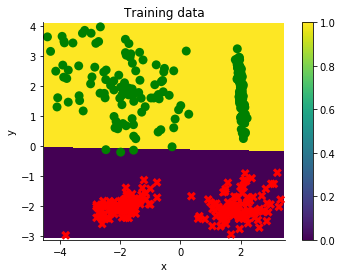

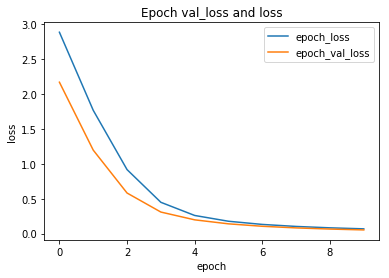

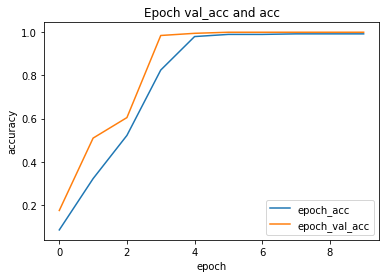


Avg. validation accuracy:1.0


In [2]:
layers = archs(2)[0]
# print(layers)
X_train, y, model = run_keras_2d('1', layers, 10)

('For arch: ', 0)
('For data_num:', 1)
('Keras FC: dataset=', '1')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.0193391966612 Accuracy on validation set: 1.0


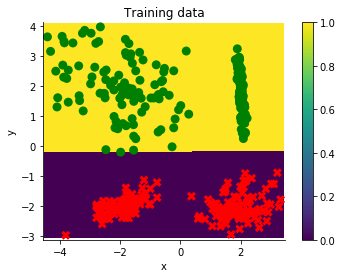

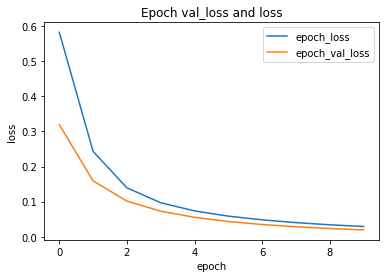

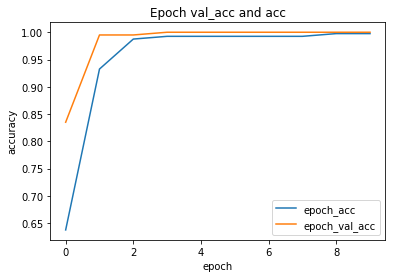


Loss on validation set:0.0450273579222 Accuracy on validation set: 1.0


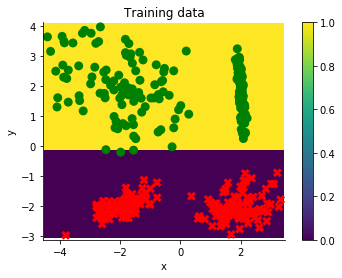

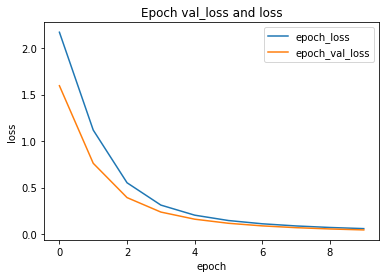

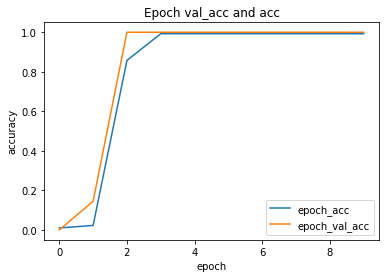


Loss on validation set:0.0210150210689 Accuracy on validation set: 1.0


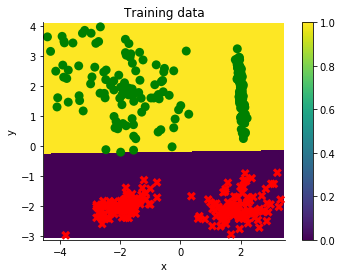

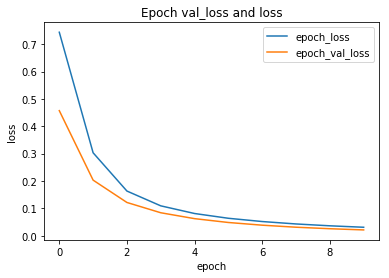

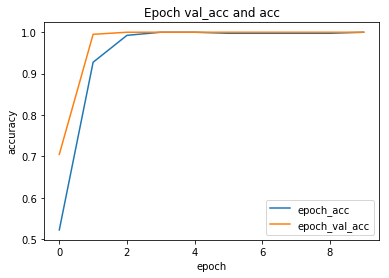


Loss on validation set:0.0244641599766 Accuracy on validation set: 1.0


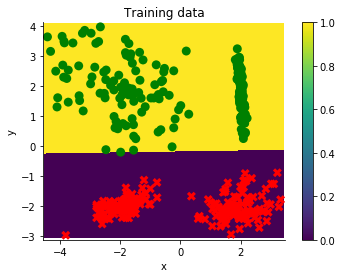

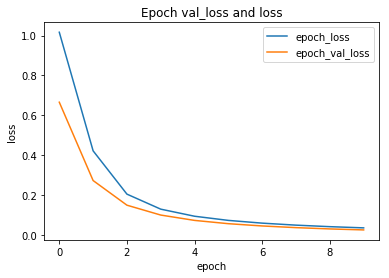

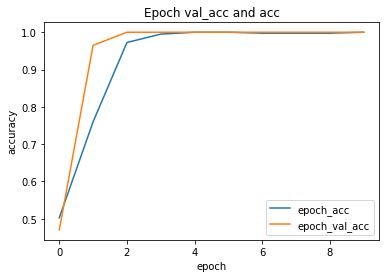


Loss on validation set:0.0191324587334 Accuracy on validation set: 1.0


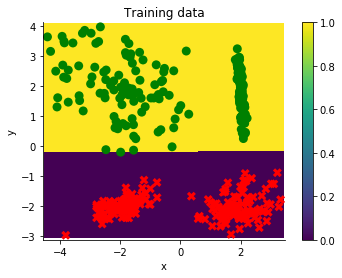

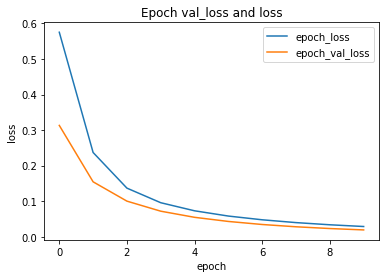

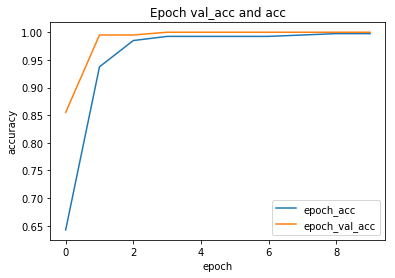


Avg. validation accuracy:1.0
('For data_num:', 2)
('Keras FC: dataset=', '2')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.386345063216 Accuracy on validation set: 0.835


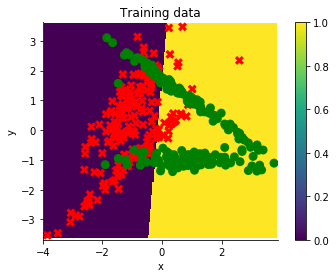

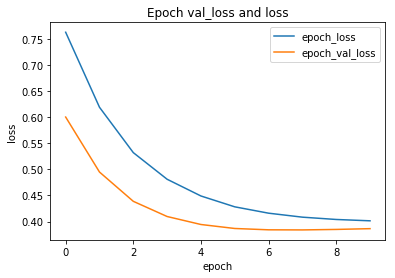

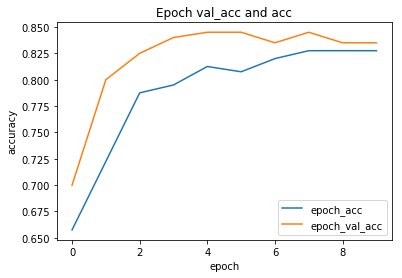


Loss on validation set:0.390613087844 Accuracy on validation set: 0.825


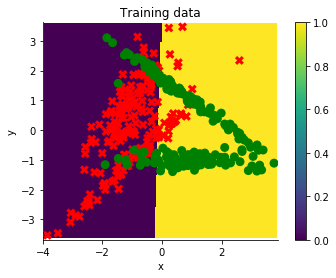

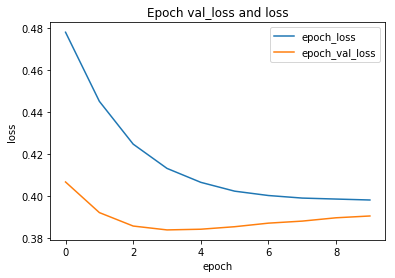

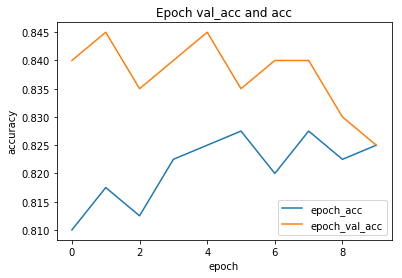


Loss on validation set:0.397630902397 Accuracy on validation set: 0.815


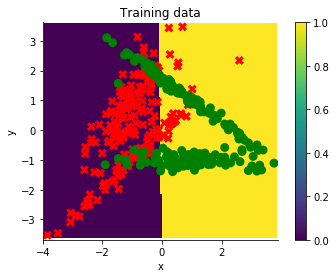

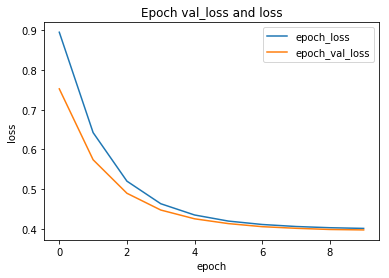

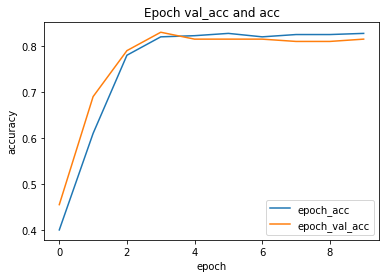


Loss on validation set:0.391301148488 Accuracy on validation set: 0.83


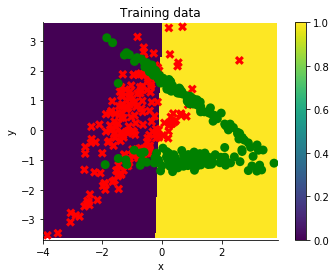

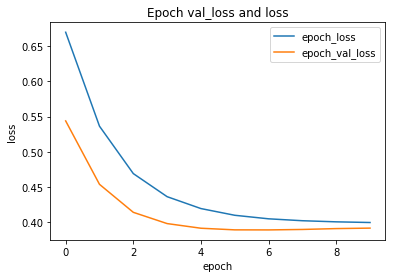

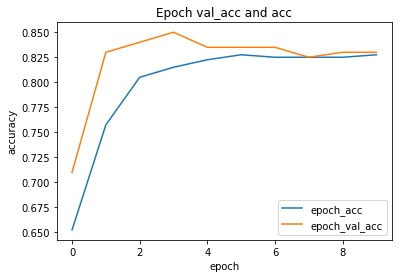


Loss on validation set:0.392408148431 Accuracy on validation set: 0.83


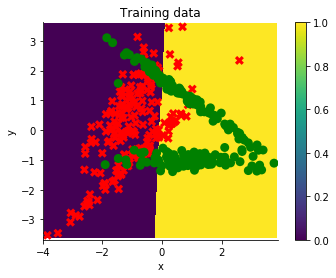

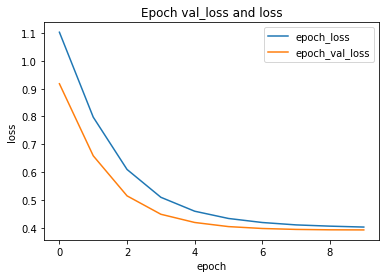

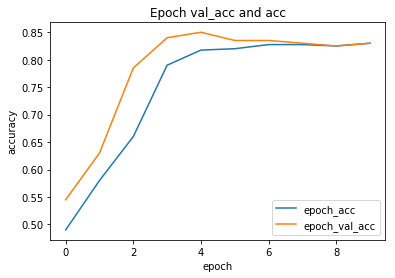


Avg. validation accuracy:0.827
('For data_num:', 3)
('Keras FC: dataset=', '3')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.127268808935 Accuracy on validation set: 0.95


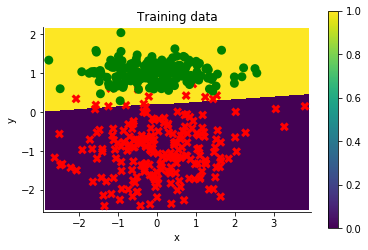

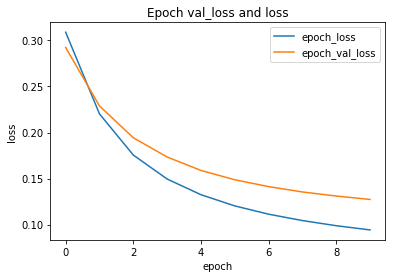

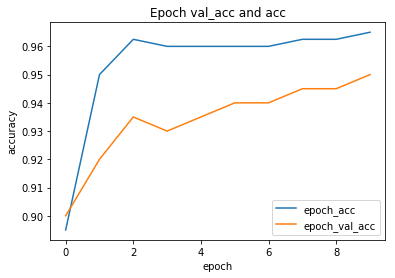


Loss on validation set:0.173732977801 Accuracy on validation set: 0.94


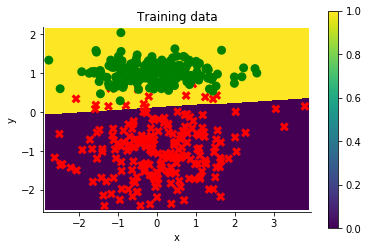

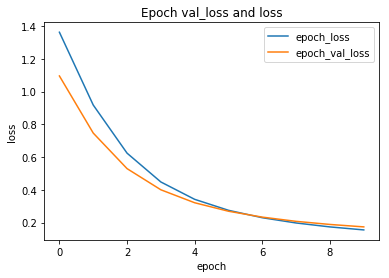

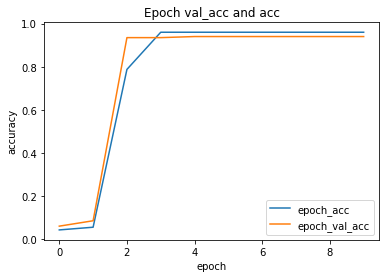


Loss on validation set:0.134819117072 Accuracy on validation set: 0.945


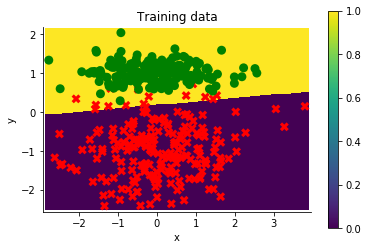

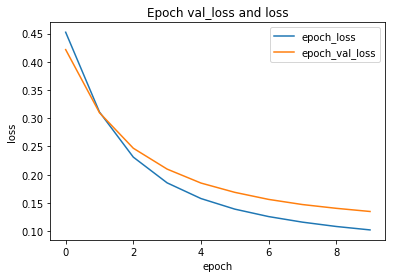

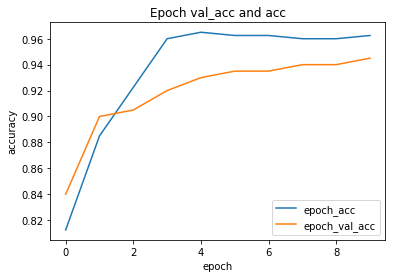


Loss on validation set:0.145024929248 Accuracy on validation set: 0.94


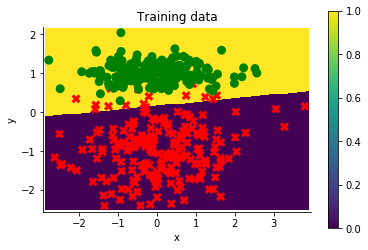

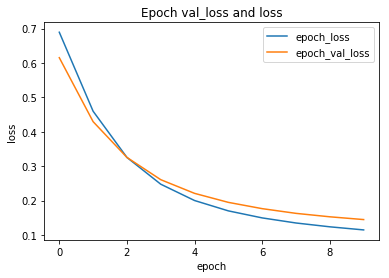

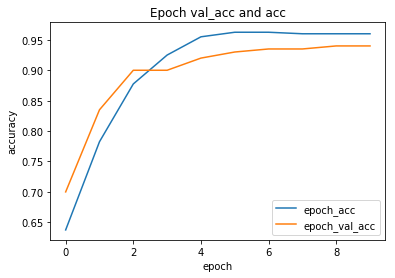


Loss on validation set:0.131719879072 Accuracy on validation set: 0.95


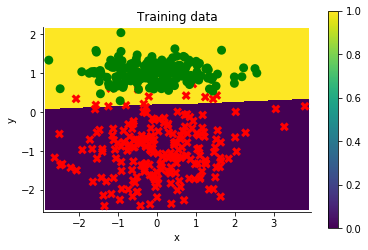

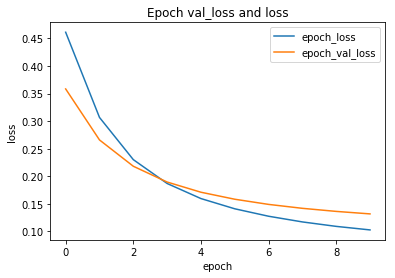

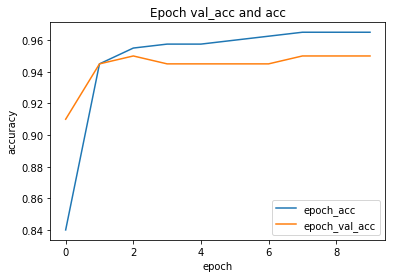


Avg. validation accuracy:0.945
('For data_num:', 4)
('Keras FC: dataset=', '4')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.693365964592 Accuracy on validation set: 0.4775


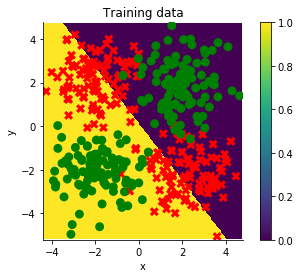

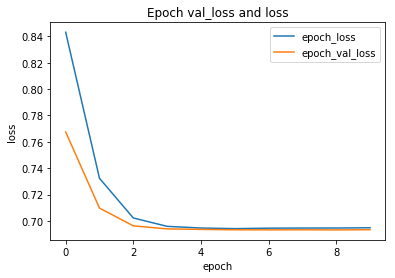

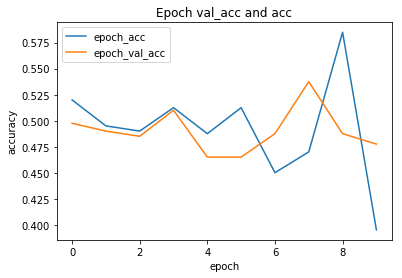


Loss on validation set:0.693188655376 Accuracy on validation set: 0.49


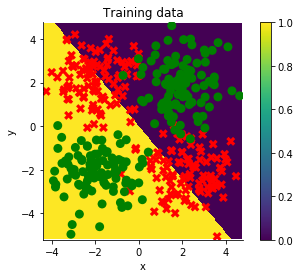

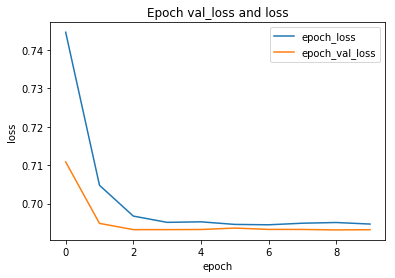

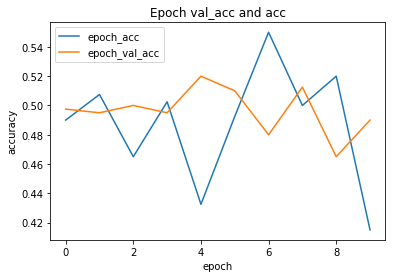


Loss on validation set:0.693319116384 Accuracy on validation set: 0.495


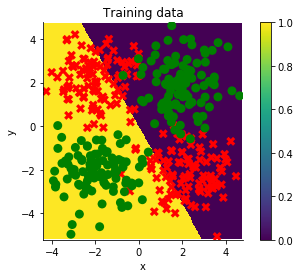

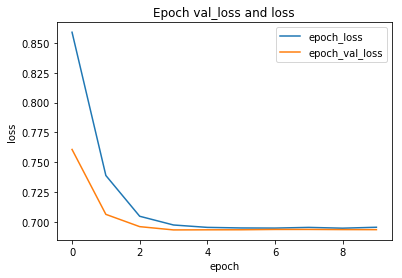

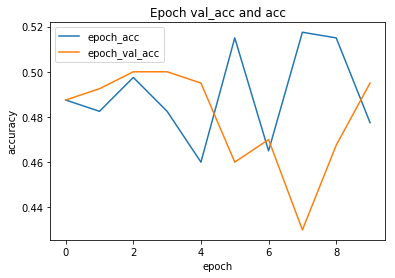


Loss on validation set:0.693336415142 Accuracy on validation set: 0.5525


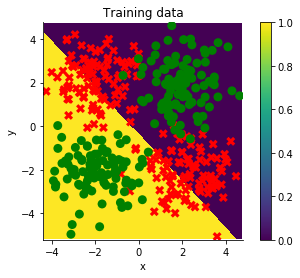

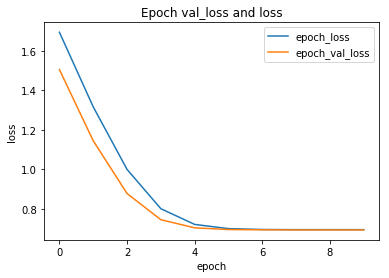

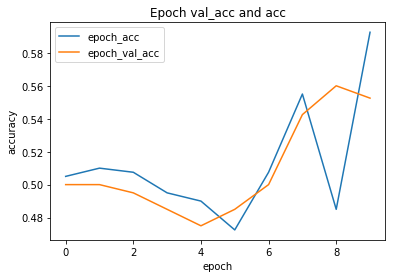


Loss on validation set:0.693329561949 Accuracy on validation set: 0.505


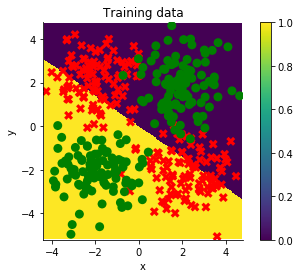

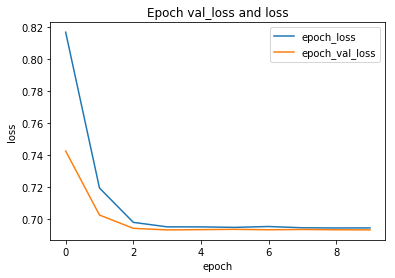

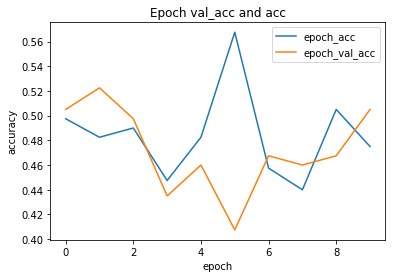


Avg. validation accuracy:0.504
('For arch: ', 1)
('For data_num:', 1)
('Keras FC: dataset=', '1')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.00194402729962 Accuracy on validation set: 1.0


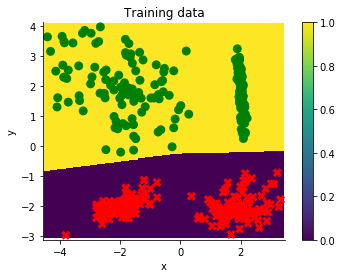

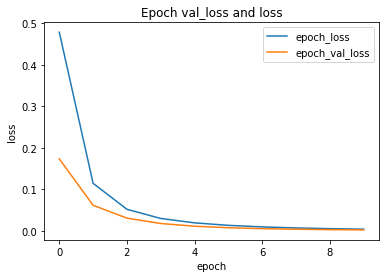

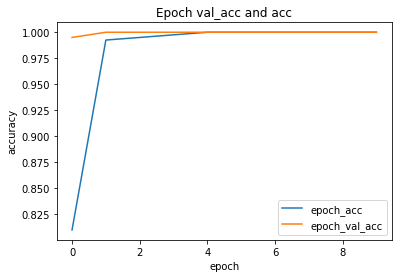


Loss on validation set:0.00129161603555 Accuracy on validation set: 1.0


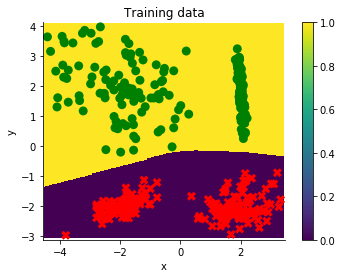

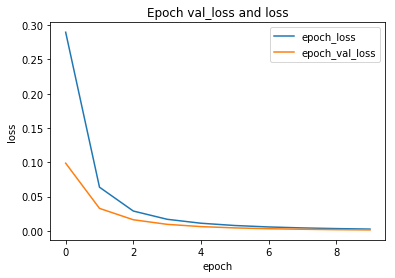

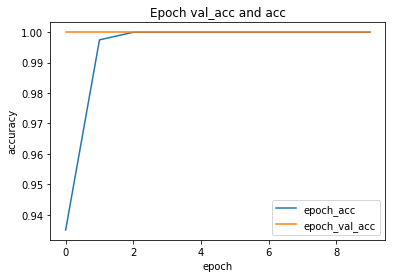


Loss on validation set:0.00164811742756 Accuracy on validation set: 1.0


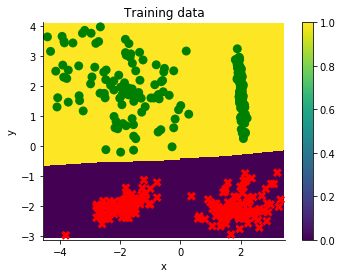

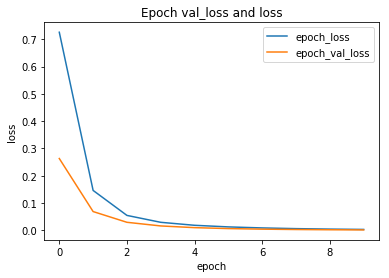

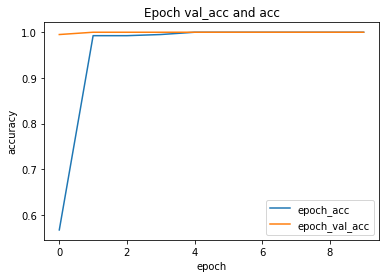


Loss on validation set:0.00161499991397 Accuracy on validation set: 1.0


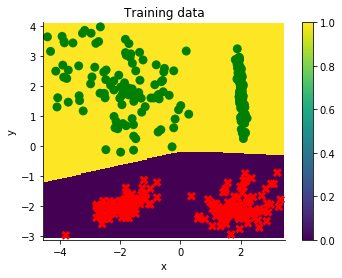

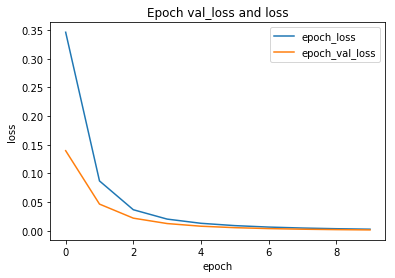

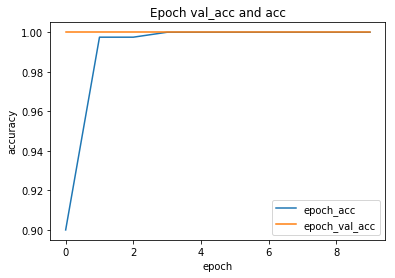


Loss on validation set:0.00113186058493 Accuracy on validation set: 1.0


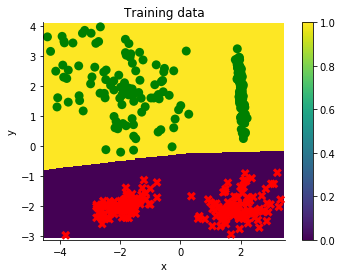

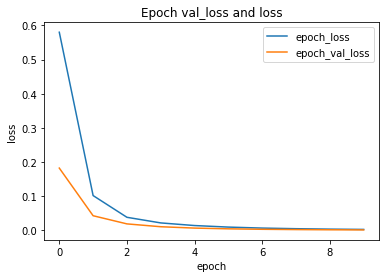

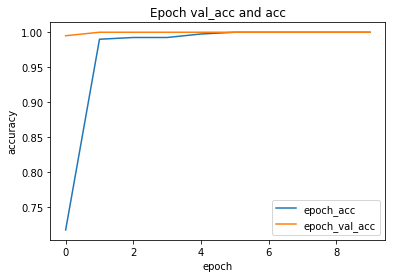


Avg. validation accuracy:1.0
('For data_num:', 2)
('Keras FC: dataset=', '2')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.32895347151 Accuracy on validation set: 0.865


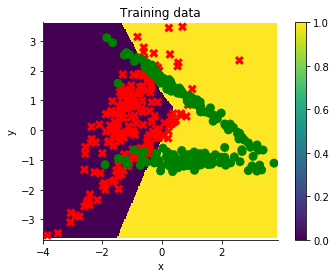

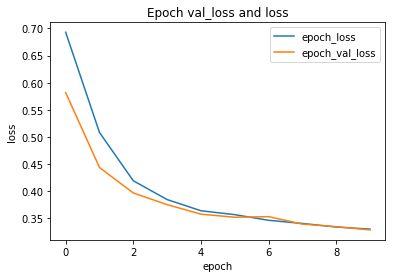

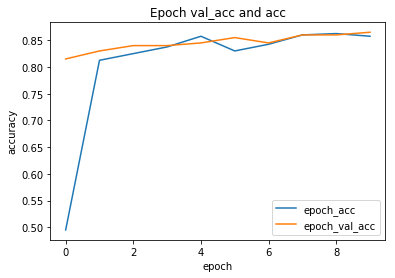


Loss on validation set:0.319815975252 Accuracy on validation set: 0.88


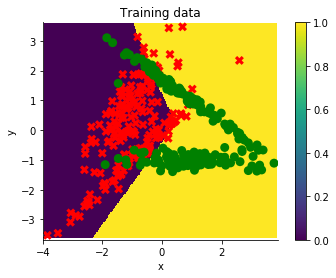

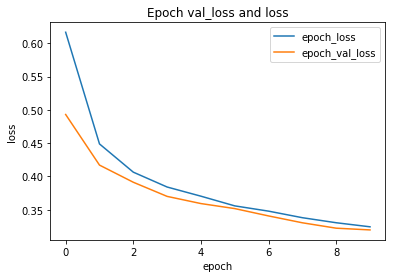

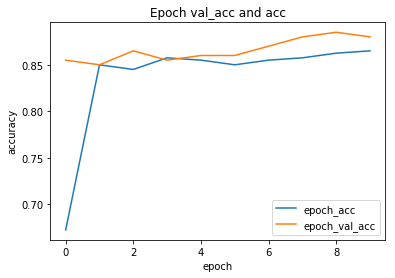


Loss on validation set:0.318324517164 Accuracy on validation set: 0.865


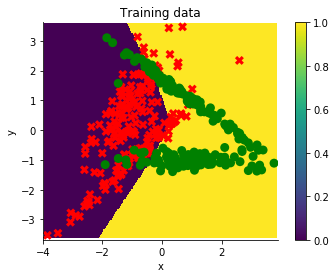

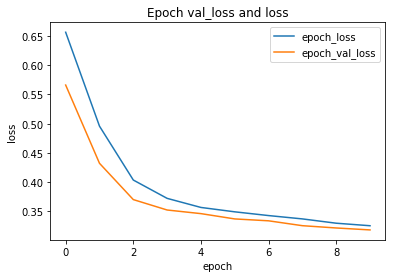

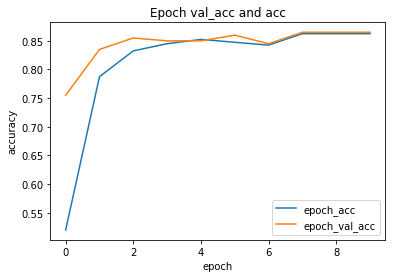


Loss on validation set:0.308612603227 Accuracy on validation set: 0.885


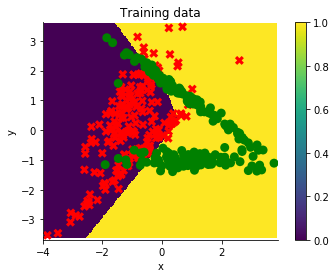

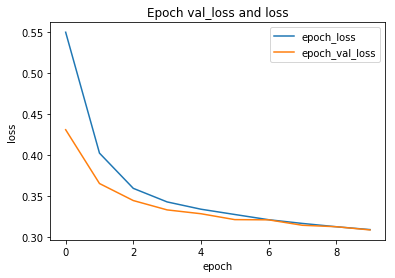

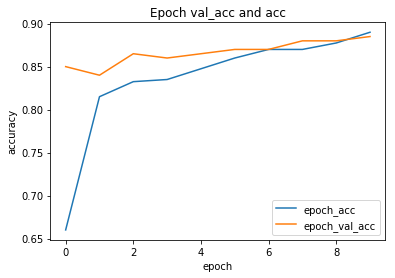


Loss on validation set:0.305465506404 Accuracy on validation set: 0.88


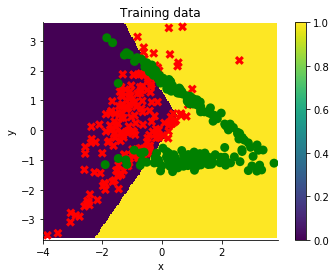

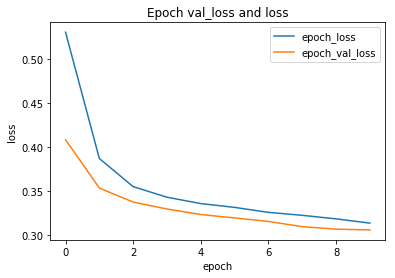

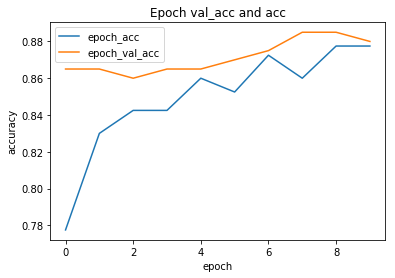


Avg. validation accuracy:0.875
('For data_num:', 3)
('Keras FC: dataset=', '3')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.102253789473 Accuracy on validation set: 0.965


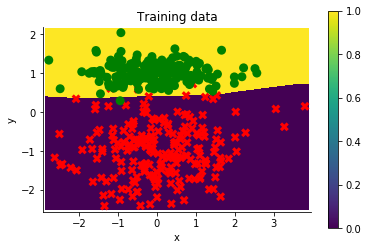

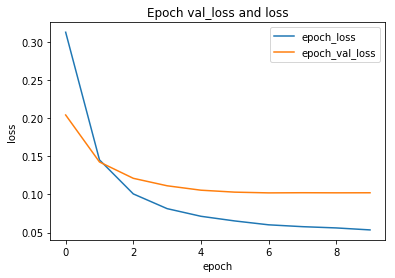

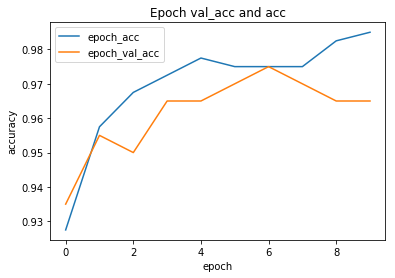


Loss on validation set:0.108462542551 Accuracy on validation set: 0.97


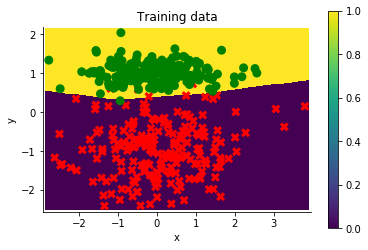

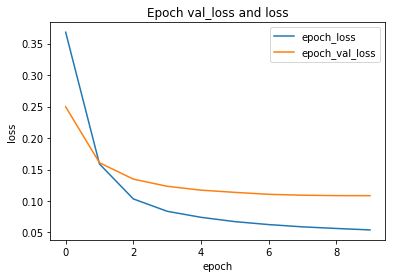

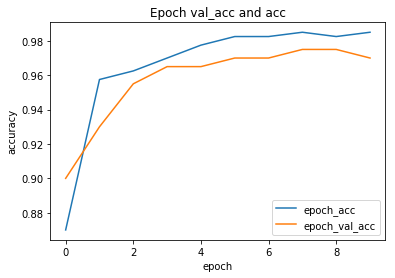


Loss on validation set:0.105764114805 Accuracy on validation set: 0.975


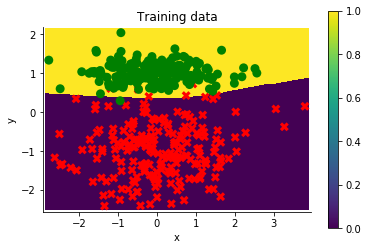

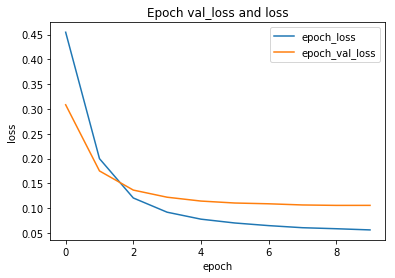

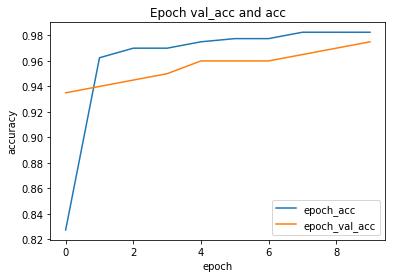


Loss on validation set:0.105518190892 Accuracy on validation set: 0.975


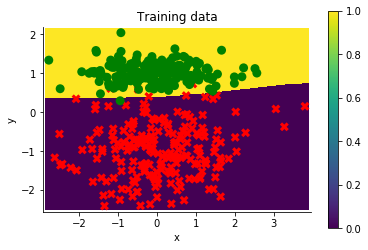

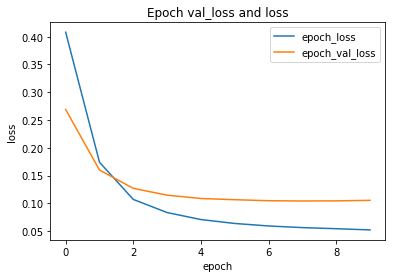

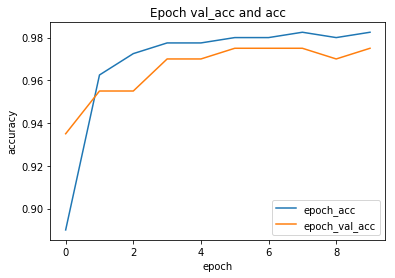


Loss on validation set:0.104893633521 Accuracy on validation set: 0.975


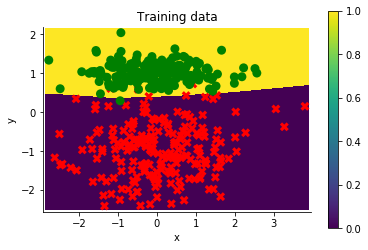

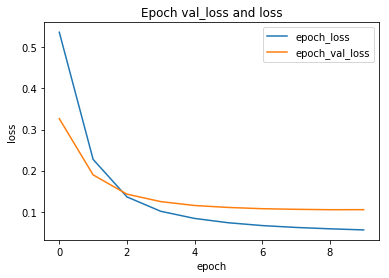

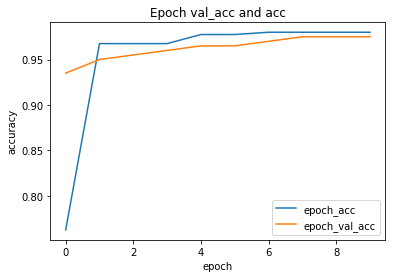


Avg. validation accuracy:0.972
('For data_num:', 4)
('Keras FC: dataset=', '4')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.124860334679 Accuracy on validation set: 0.95


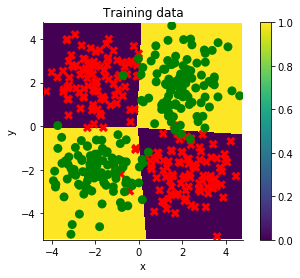

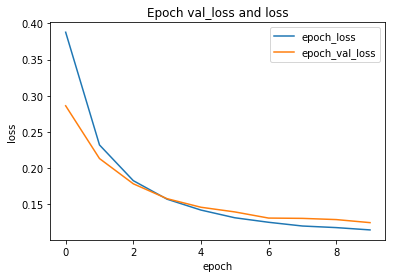

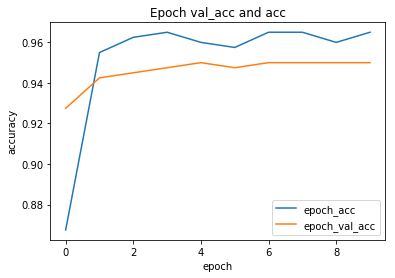


Loss on validation set:0.124825816442 Accuracy on validation set: 0.955


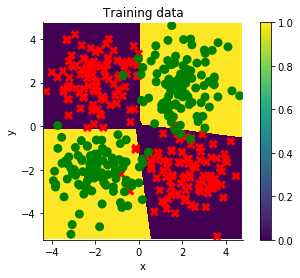

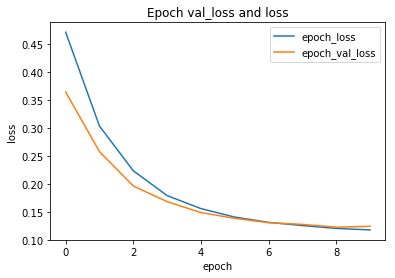

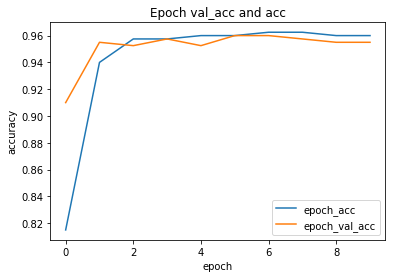


Loss on validation set:0.129574270149 Accuracy on validation set: 0.9475


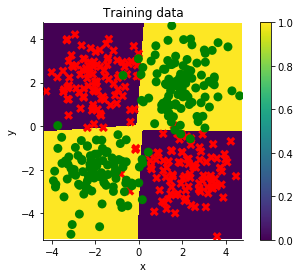

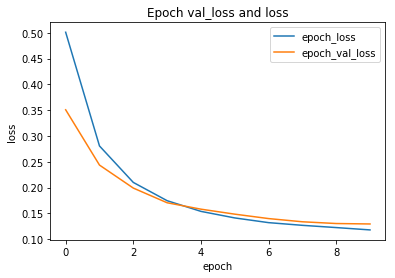

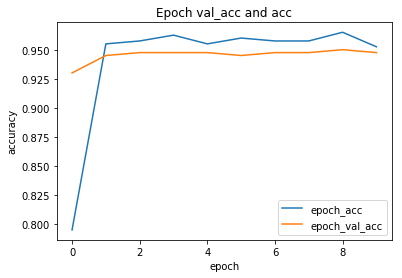


Loss on validation set:0.129035748799 Accuracy on validation set: 0.9475


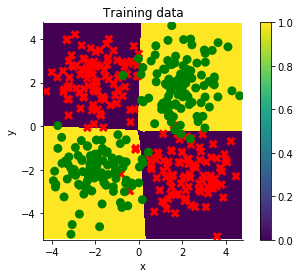

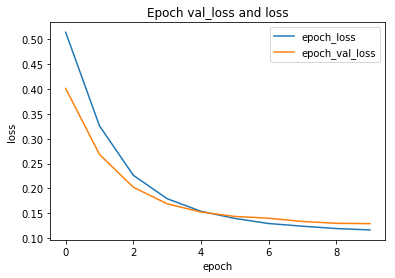

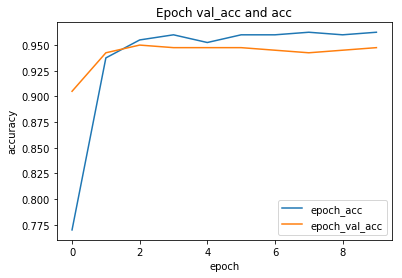


Loss on validation set:0.127643821722 Accuracy on validation set: 0.9525


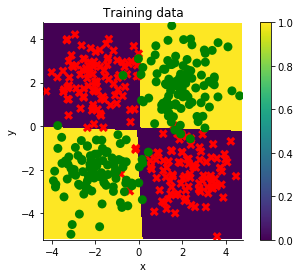

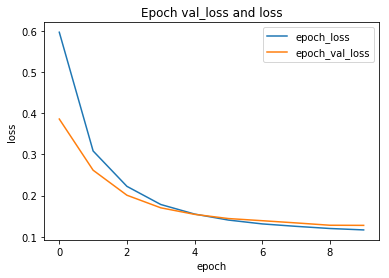

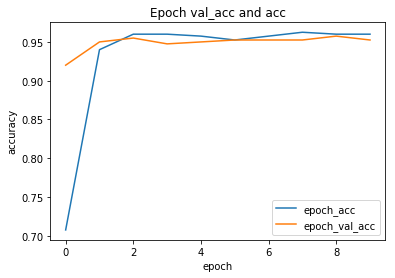


Avg. validation accuracy:0.9505
('For arch: ', 2)
('For data_num:', 1)
('Keras FC: dataset=', '1')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:9.48767371492e-05 Accuracy on validation set: 1.0


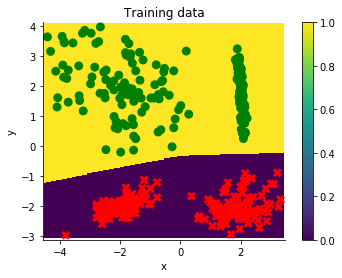

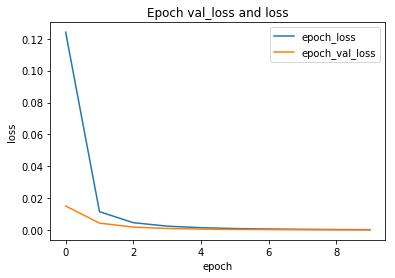

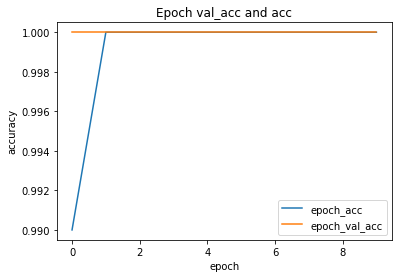


Loss on validation set:0.000105726245004 Accuracy on validation set: 1.0


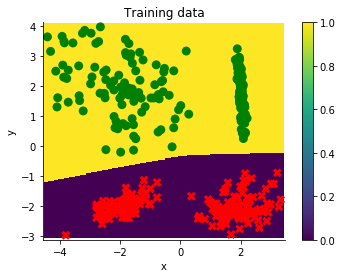

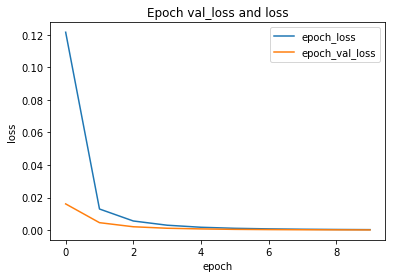

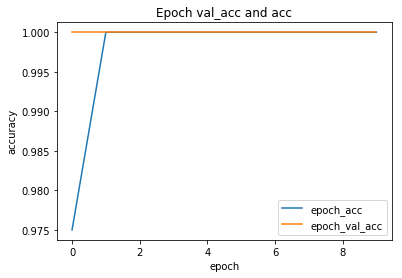


Loss on validation set:0.000115407984909 Accuracy on validation set: 1.0


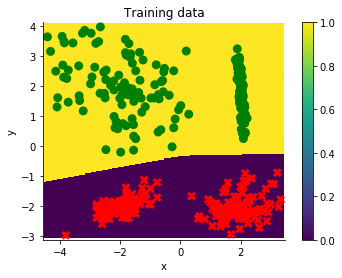

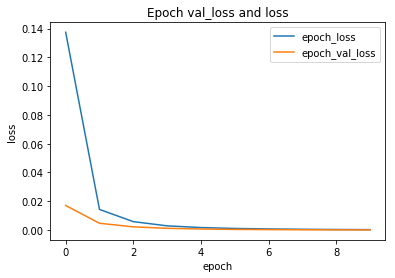

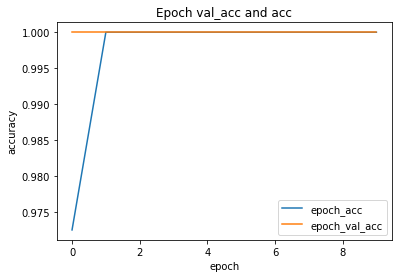


Loss on validation set:0.000142789096818 Accuracy on validation set: 1.0


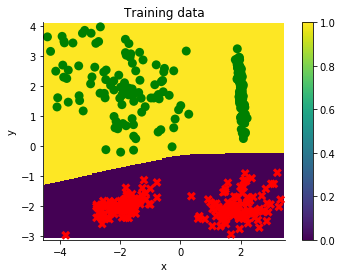

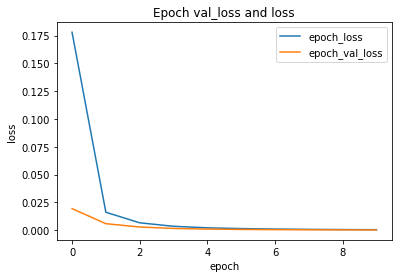

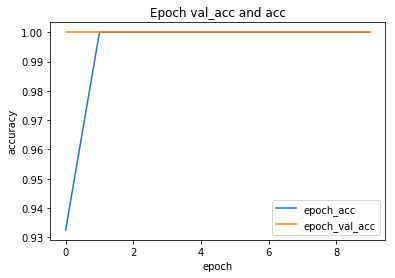


Loss on validation set:0.000100914013158 Accuracy on validation set: 1.0


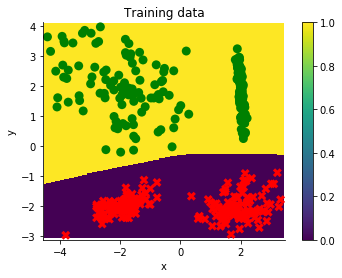

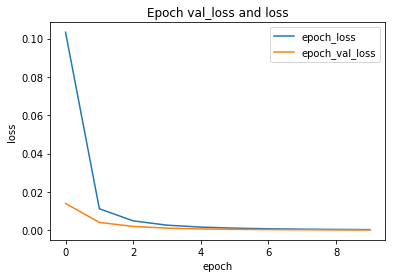

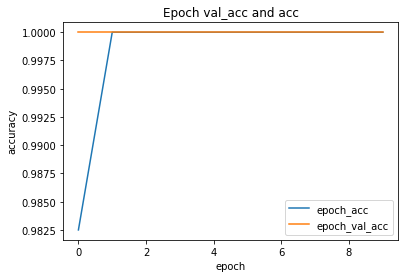


Avg. validation accuracy:1.0
('For data_num:', 2)
('Keras FC: dataset=', '2')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.28569830241 Accuracy on validation set: 0.88


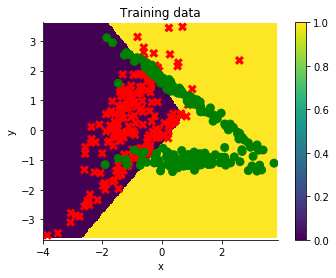

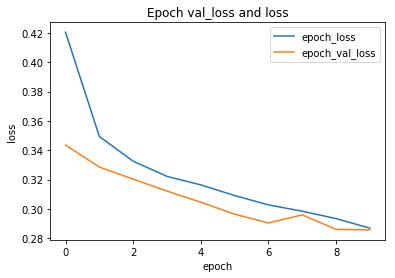

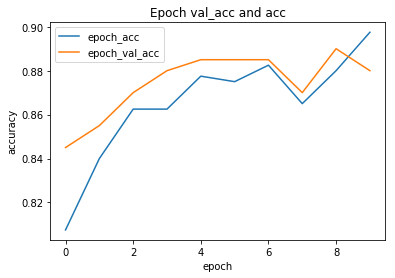


Loss on validation set:0.279231447191 Accuracy on validation set: 0.875


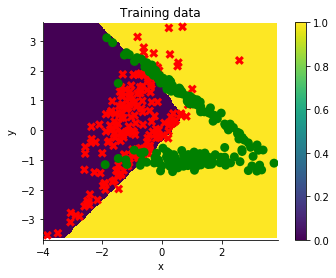

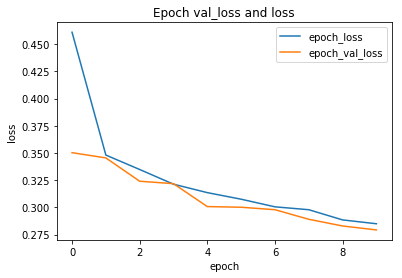

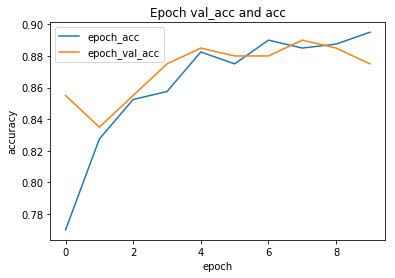


Loss on validation set:0.281602321581 Accuracy on validation set: 0.895


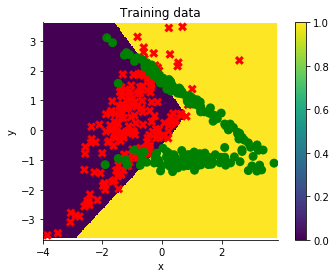

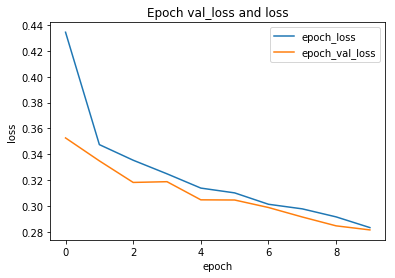

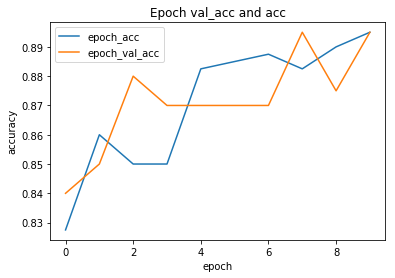


Loss on validation set:0.290260987466 Accuracy on validation set: 0.875


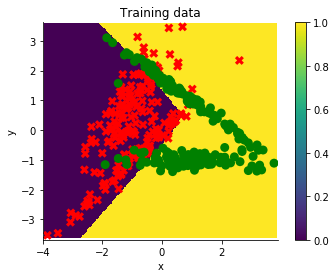

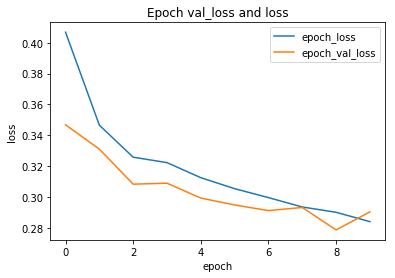

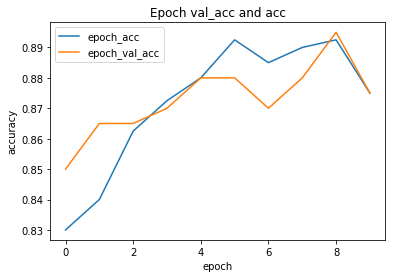


Loss on validation set:0.286582508985 Accuracy on validation set: 0.885


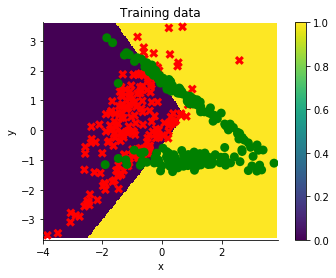

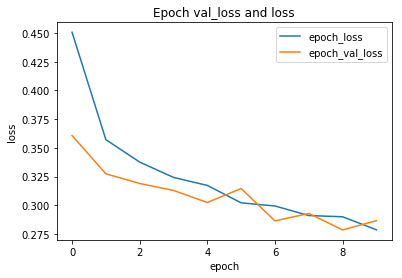

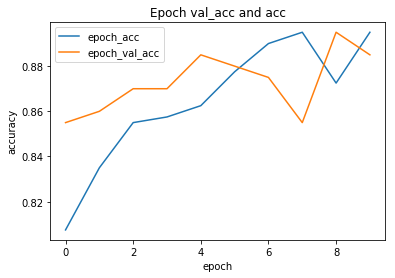


Avg. validation accuracy:0.882
('For data_num:', 3)
('Keras FC: dataset=', '3')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.115776121263 Accuracy on validation set: 0.965


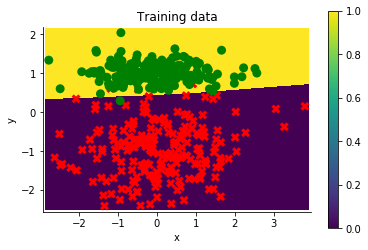

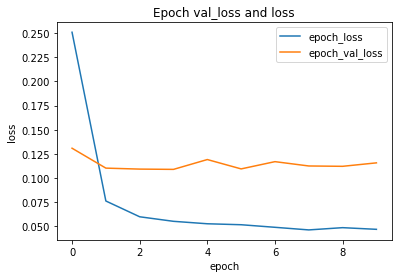

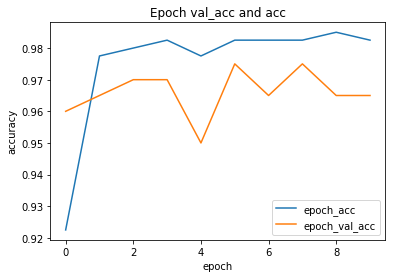


Loss on validation set:0.114167881186 Accuracy on validation set: 0.96


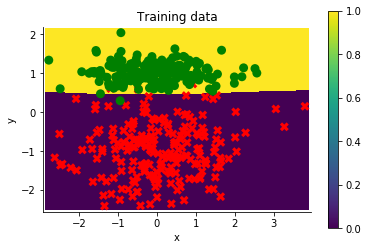

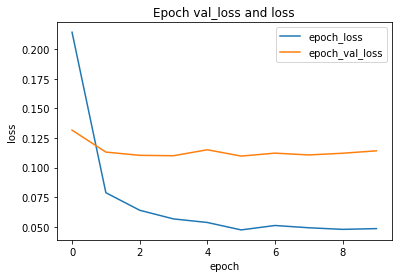

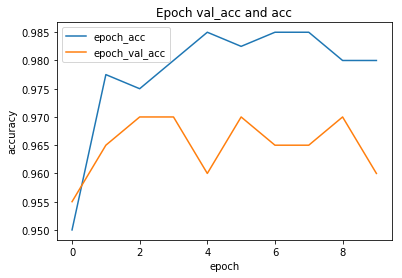


Loss on validation set:0.114573688916 Accuracy on validation set: 0.965


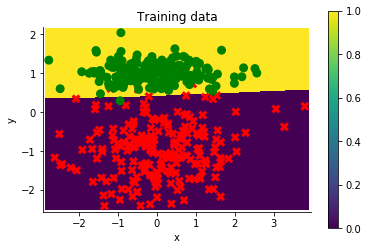

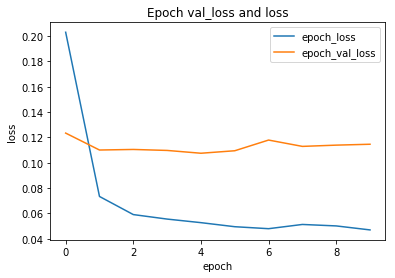

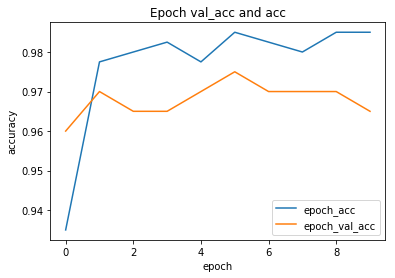


Loss on validation set:0.118688151965 Accuracy on validation set: 0.97


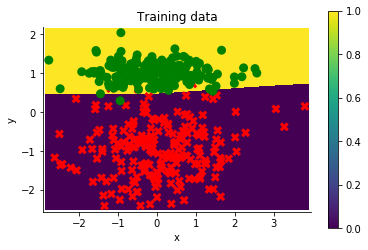

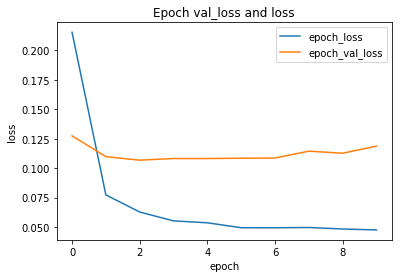

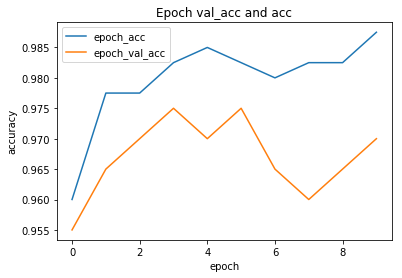


Loss on validation set:0.114977239104 Accuracy on validation set: 0.965


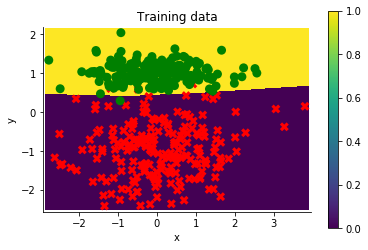

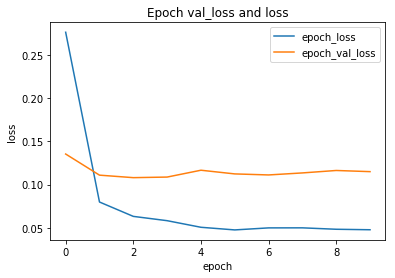

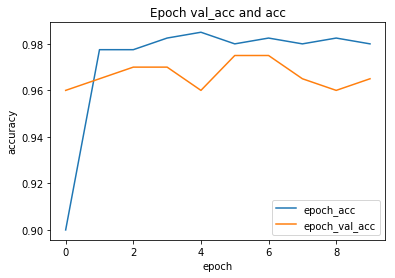


Avg. validation accuracy:0.965
('For data_num:', 4)
('Keras FC: dataset=', '4')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.13720791785 Accuracy on validation set: 0.9475


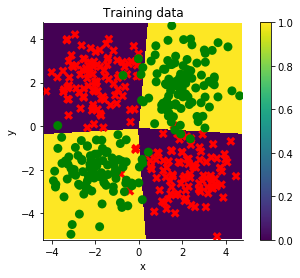

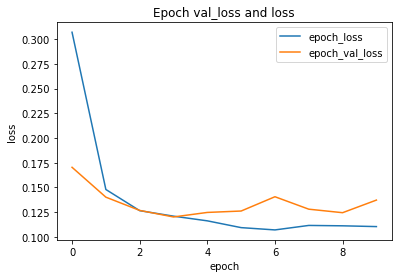

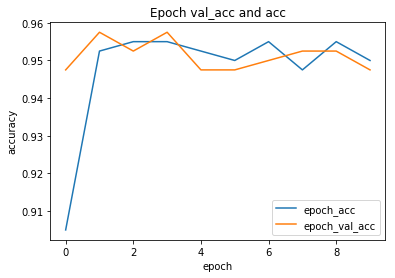


Loss on validation set:0.125776707073 Accuracy on validation set: 0.955


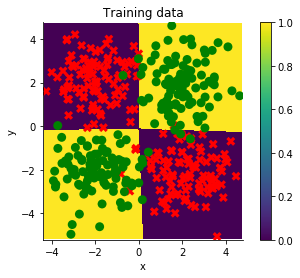

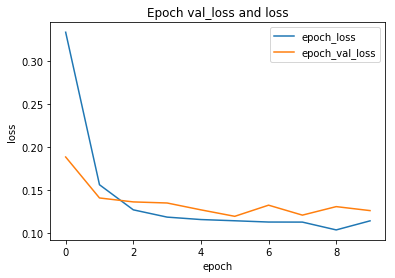

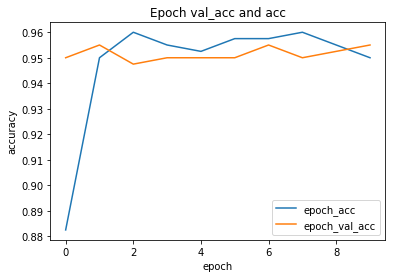


Loss on validation set:0.117983762702 Accuracy on validation set: 0.9525


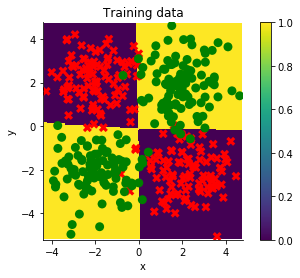

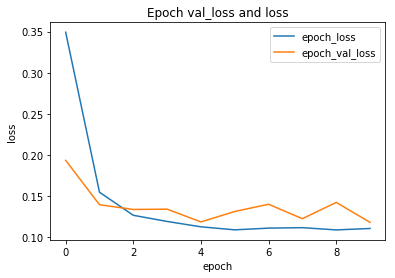

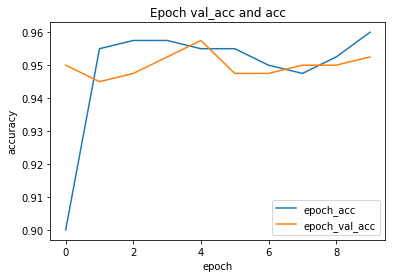


Loss on validation set:0.119161414973 Accuracy on validation set: 0.955


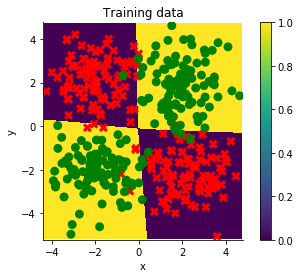

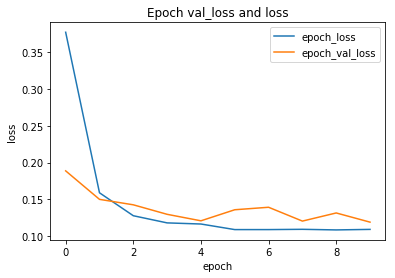

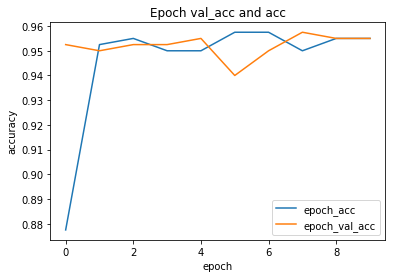


Loss on validation set:0.128788089717 Accuracy on validation set: 0.95


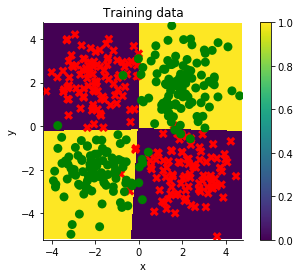

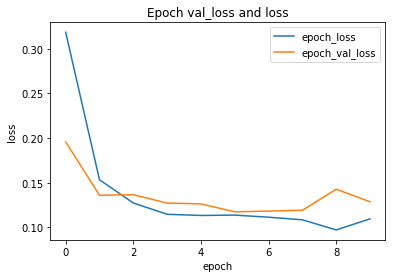

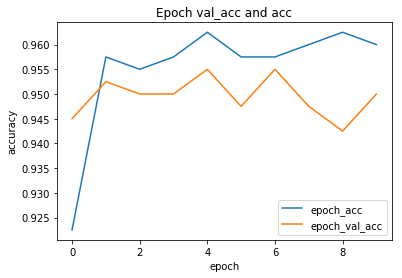


Avg. validation accuracy:0.952
('For arch: ', 3)
('For data_num:', 1)
('Keras FC: dataset=', '1')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.000235756348466 Accuracy on validation set: 1.0


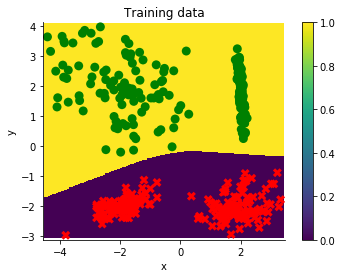

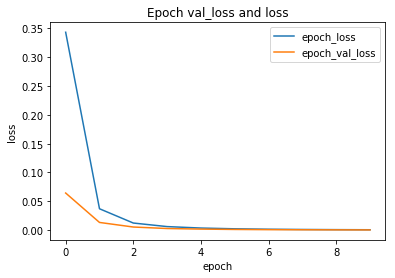

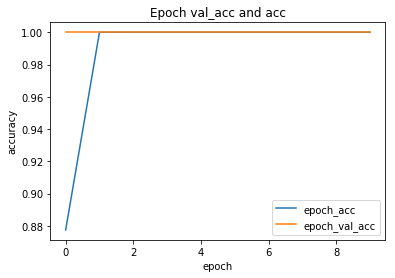


Loss on validation set:0.000413184129229 Accuracy on validation set: 1.0


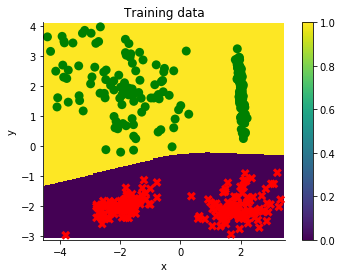

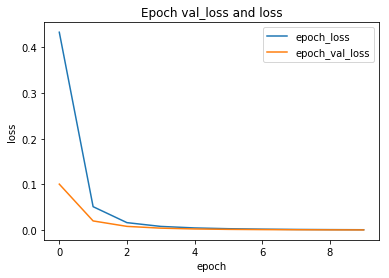

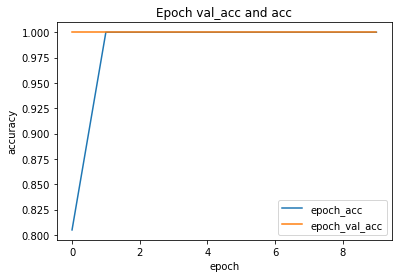


Loss on validation set:0.000325442525846 Accuracy on validation set: 1.0


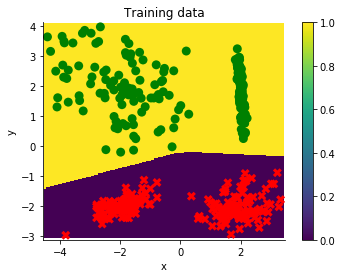

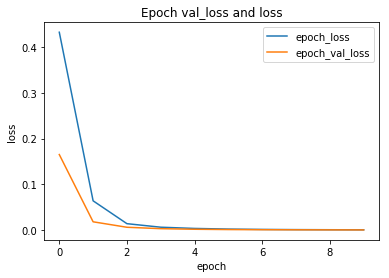

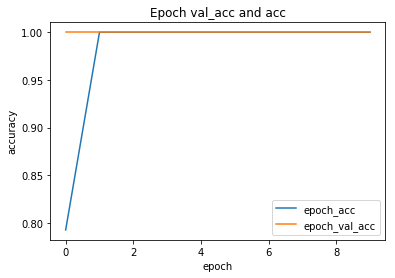


Loss on validation set:0.000194142558458 Accuracy on validation set: 1.0


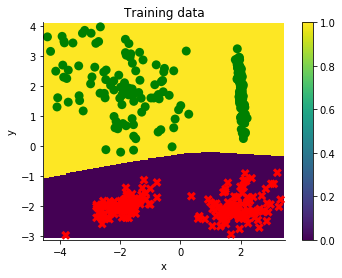

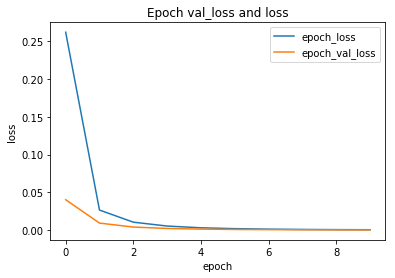

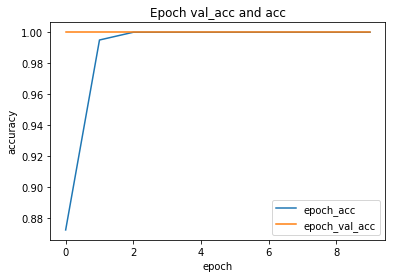


Loss on validation set:0.00022521000884 Accuracy on validation set: 1.0


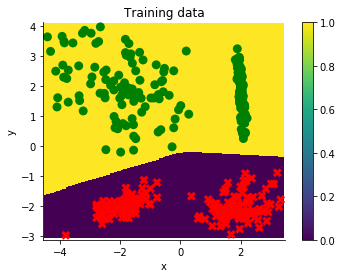

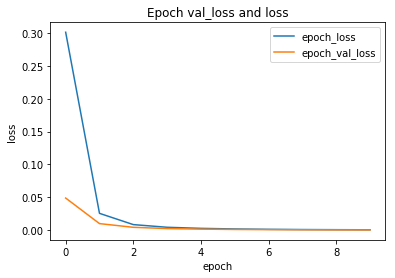

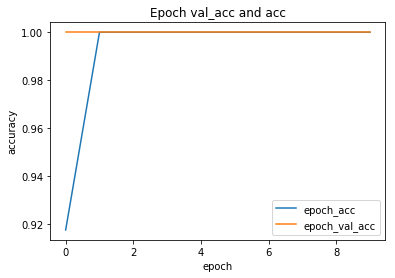


Avg. validation accuracy:1.0
('For data_num:', 2)
('Keras FC: dataset=', '2')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.273295779508 Accuracy on validation set: 0.89


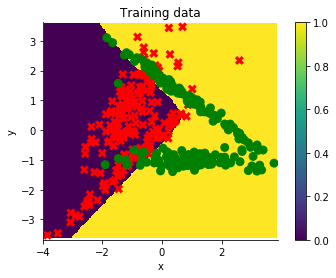

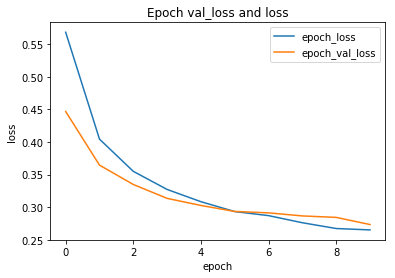

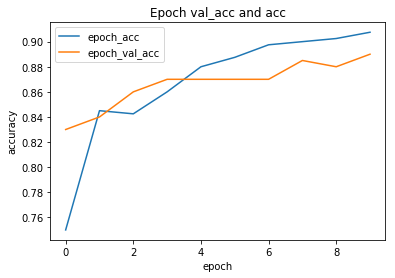


Loss on validation set:0.295064972666 Accuracy on validation set: 0.87


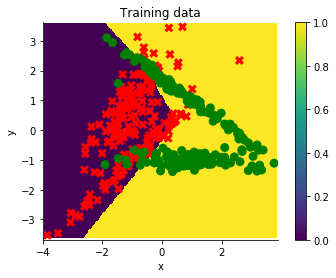

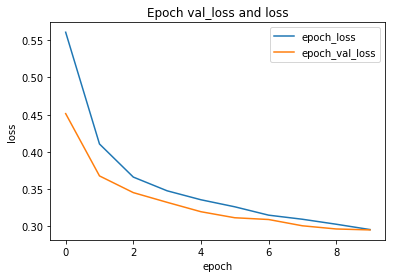

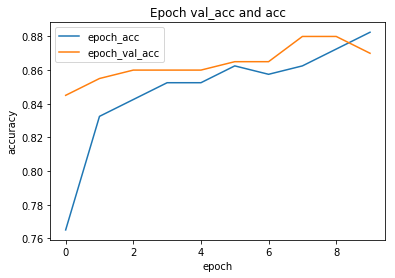


Loss on validation set:0.291267483048 Accuracy on validation set: 0.885


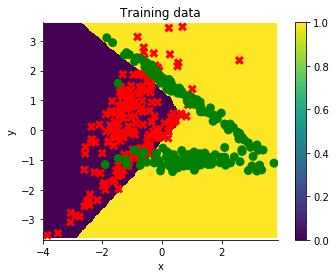

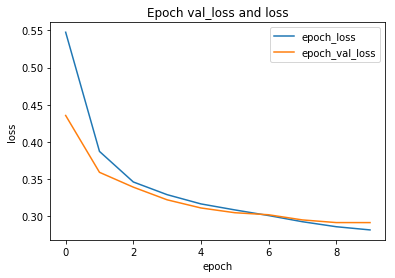

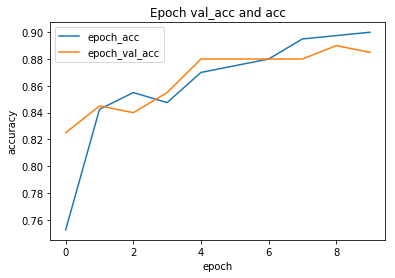


Loss on validation set:0.256477814907 Accuracy on validation set: 0.9


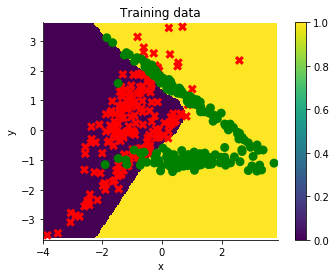

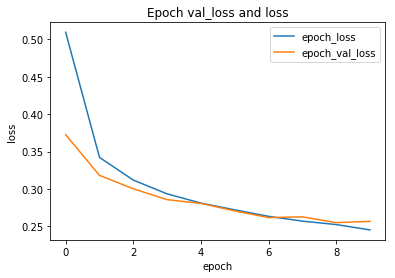

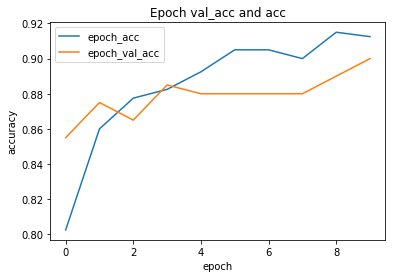


Loss on validation set:0.293775988731 Accuracy on validation set: 0.895


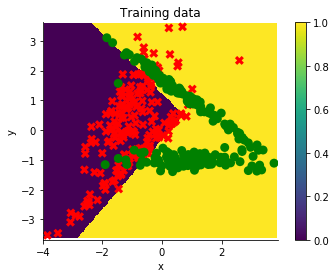

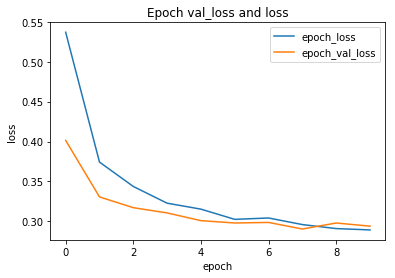

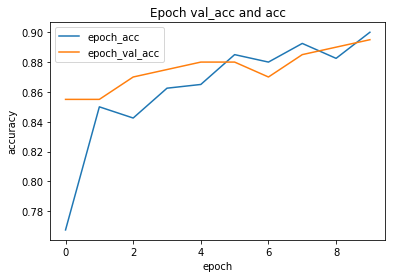


Avg. validation accuracy:0.888
('For data_num:', 3)
('Keras FC: dataset=', '3')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.116460592937 Accuracy on validation set: 0.97


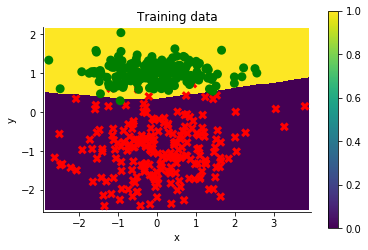

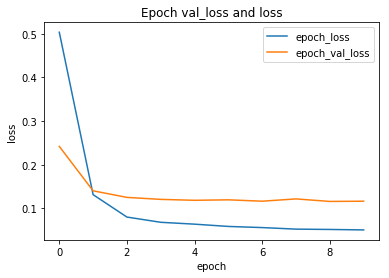

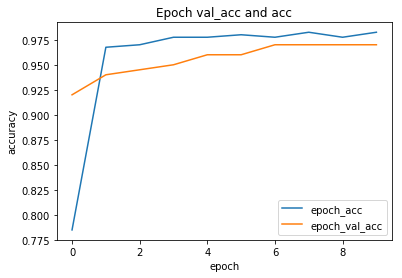


Loss on validation set:0.121367335309 Accuracy on validation set: 0.97


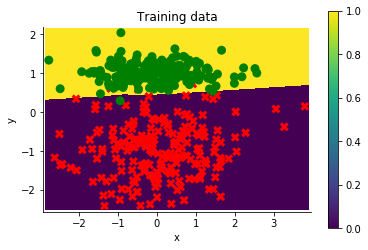

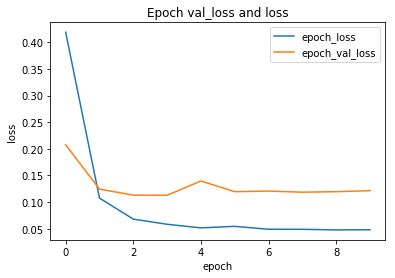

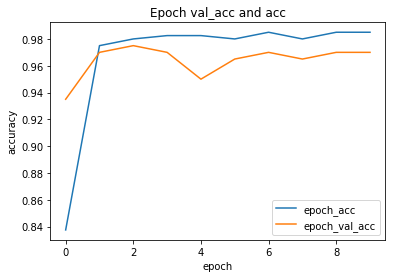


Loss on validation set:0.109676146659 Accuracy on validation set: 0.965


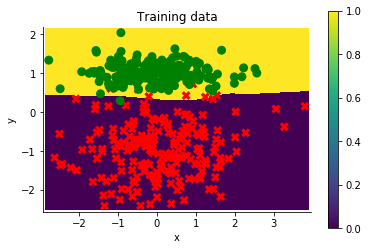

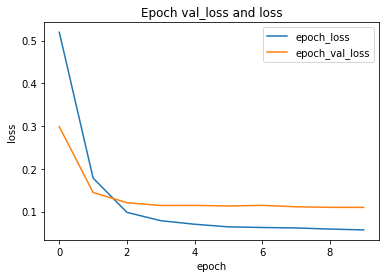

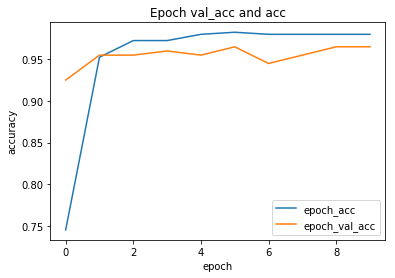


Loss on validation set:0.121280111739 Accuracy on validation set: 0.965


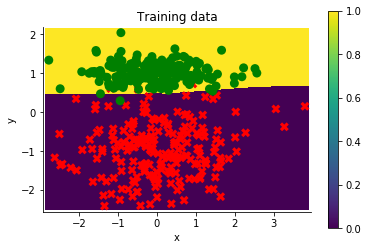

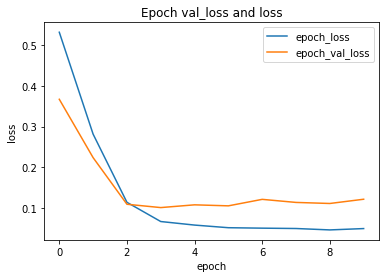

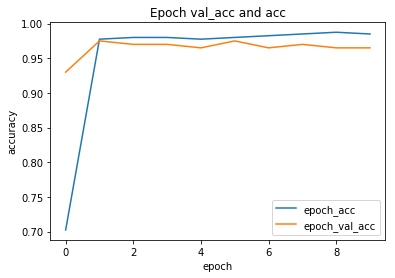


Loss on validation set:0.123688852985 Accuracy on validation set: 0.95


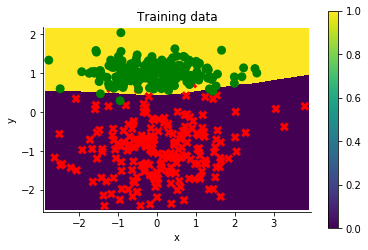

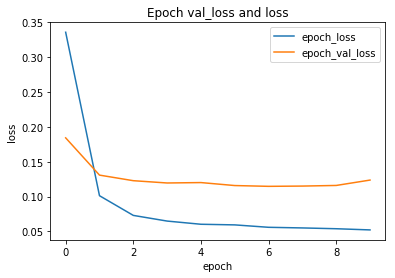

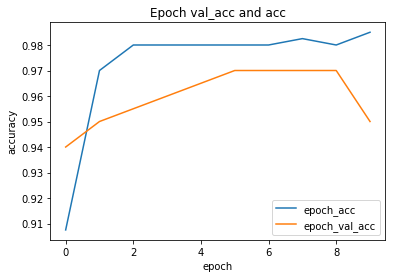


Avg. validation accuracy:0.964
('For data_num:', 4)
('Keras FC: dataset=', '4')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.120934569897 Accuracy on validation set: 0.9525


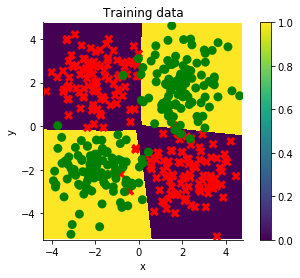

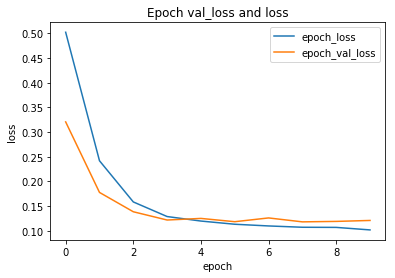

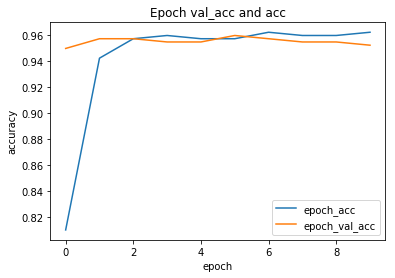


Loss on validation set:0.131155876685 Accuracy on validation set: 0.9525


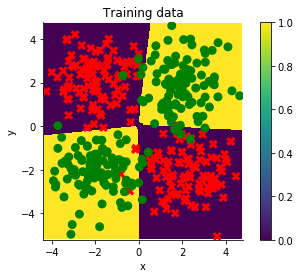

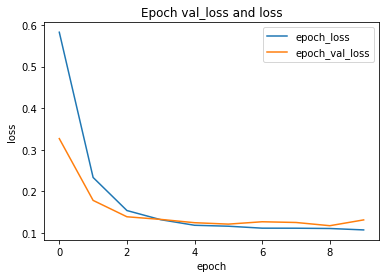

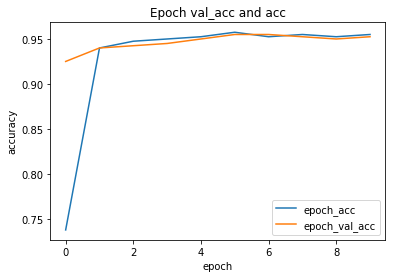


Loss on validation set:0.129351963613 Accuracy on validation set: 0.9525


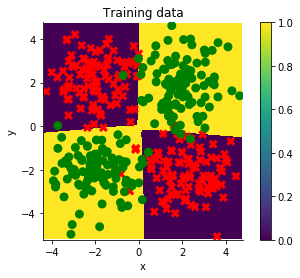

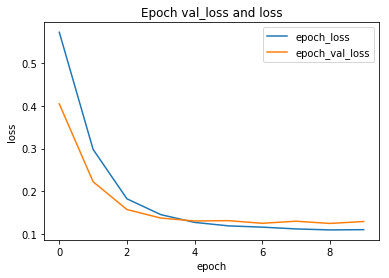

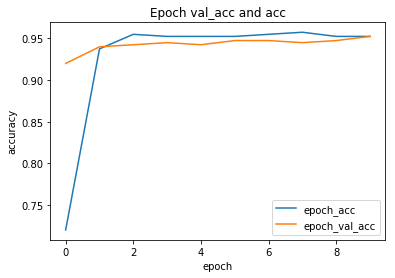


Loss on validation set:0.130714823182 Accuracy on validation set: 0.945


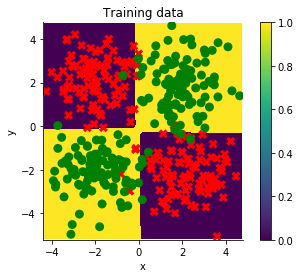

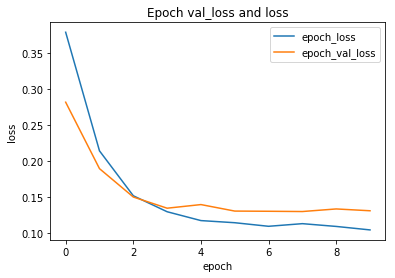

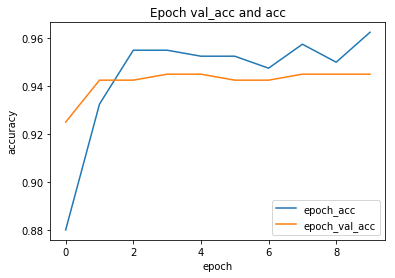


Loss on validation set:0.129203147422 Accuracy on validation set: 0.95


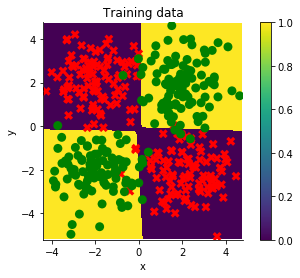

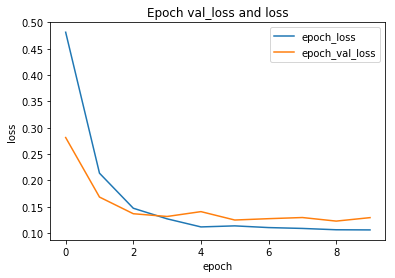

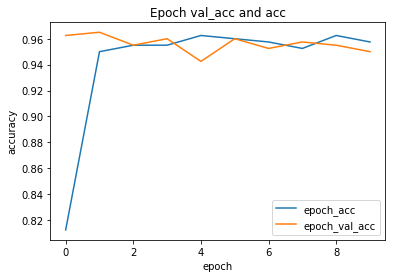


Avg. validation accuracy:0.9505
('For arch: ', 4)
('For data_num:', 1)
('Keras FC: dataset=', '1')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:1.47845700042e-05 Accuracy on validation set: 1.0


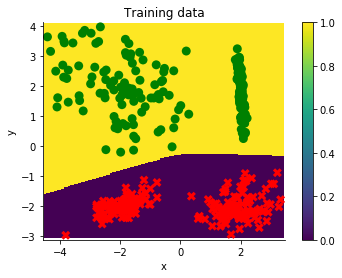

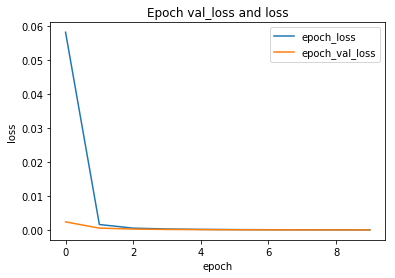

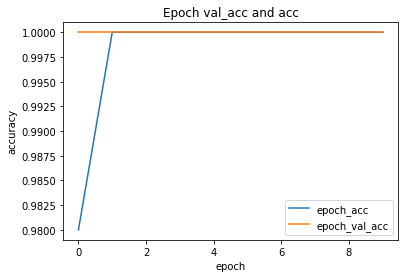


Loss on validation set:9.70170188126e-06 Accuracy on validation set: 1.0


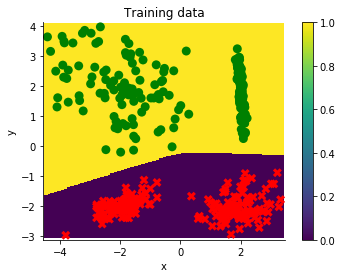

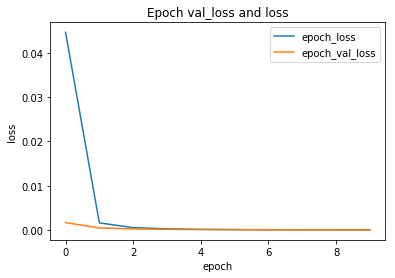

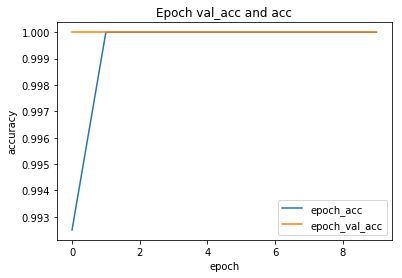


Loss on validation set:9.60160601252e-06 Accuracy on validation set: 1.0


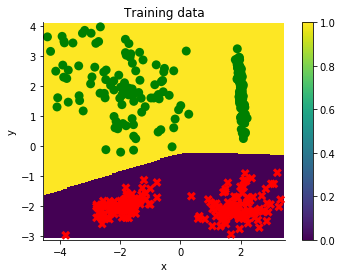

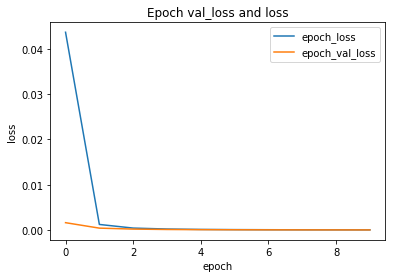

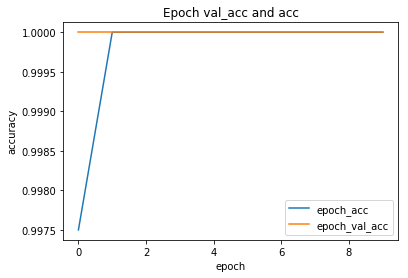


Loss on validation set:9.27315621013e-06 Accuracy on validation set: 1.0


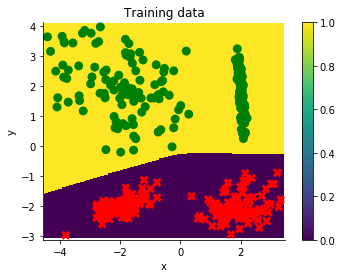

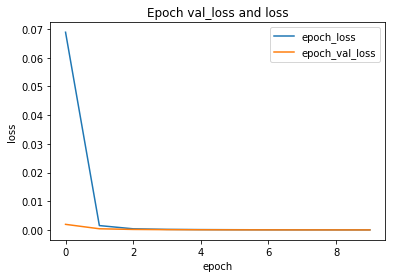

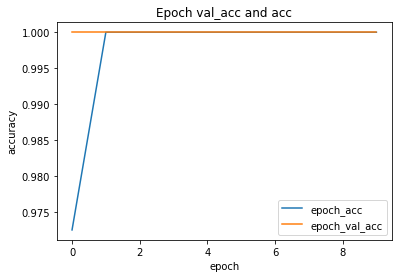


Loss on validation set:1.10706838685e-05 Accuracy on validation set: 1.0


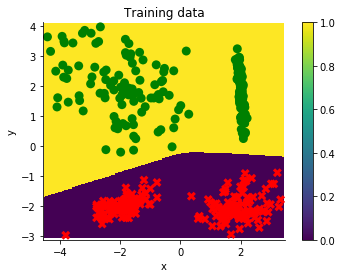

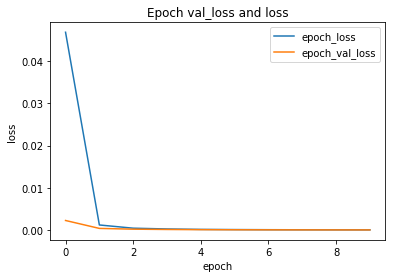

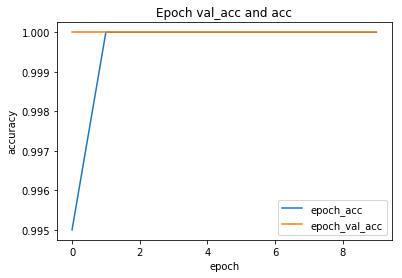


Avg. validation accuracy:1.0
('For data_num:', 2)
('Keras FC: dataset=', '2')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.204087572159 Accuracy on validation set: 0.915


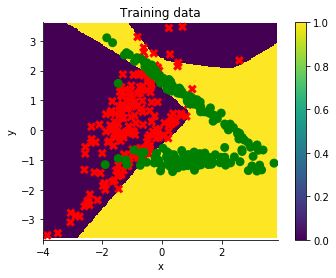

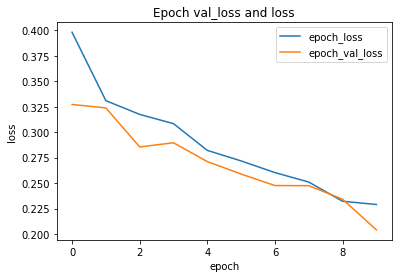

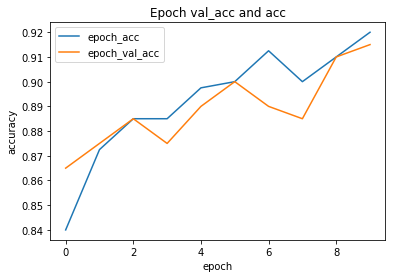


Loss on validation set:0.207782318635 Accuracy on validation set: 0.915


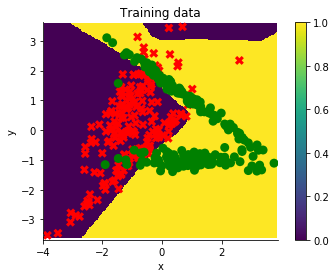

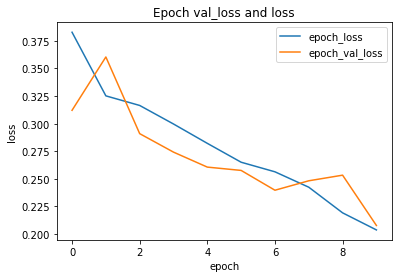

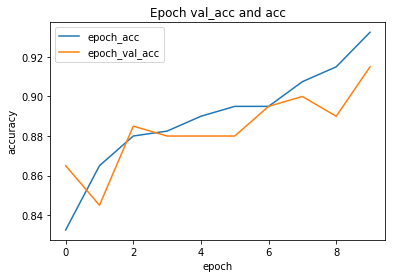


Loss on validation set:0.214755478352 Accuracy on validation set: 0.905


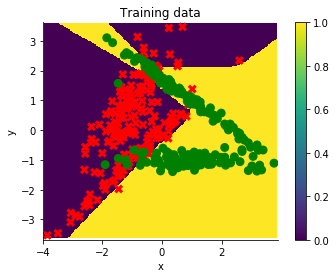

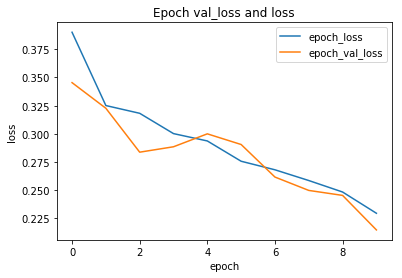

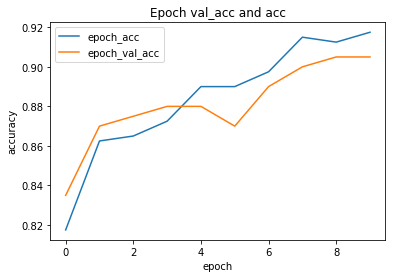


Loss on validation set:0.210986402269 Accuracy on validation set: 0.925


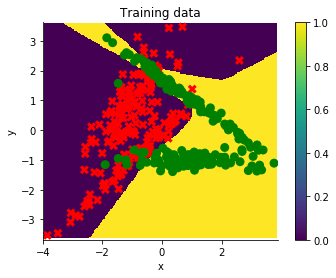

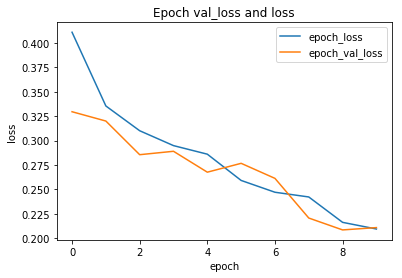

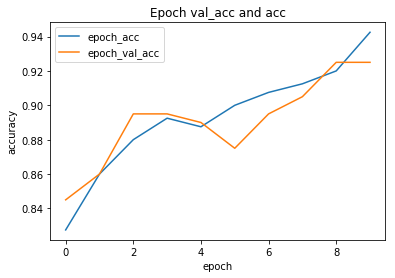


Loss on validation set:0.210761732856 Accuracy on validation set: 0.91


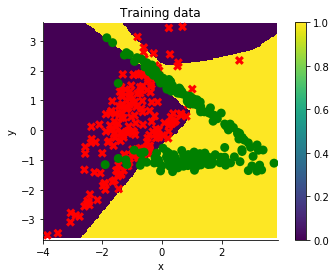

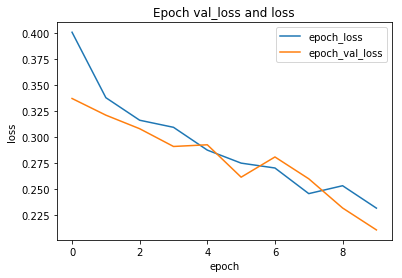

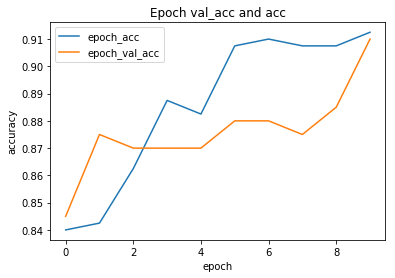


Avg. validation accuracy:0.914
('For data_num:', 3)
('Keras FC: dataset=', '3')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.13229196974 Accuracy on validation set: 0.96


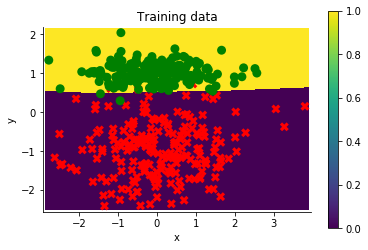

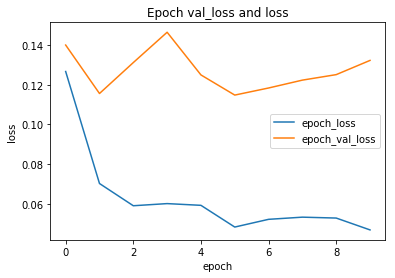

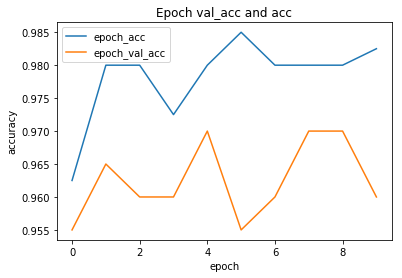


Loss on validation set:0.131689959426 Accuracy on validation set: 0.97


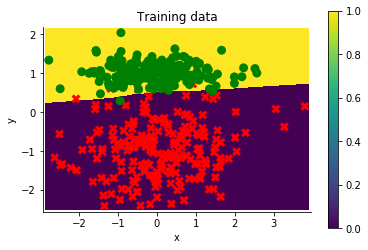

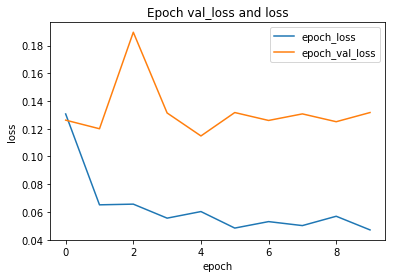

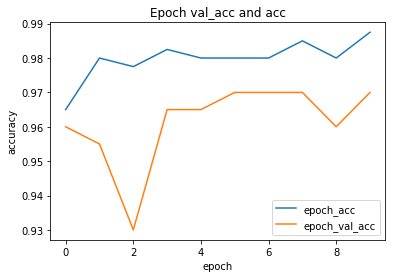


Loss on validation set:0.122434246422 Accuracy on validation set: 0.955


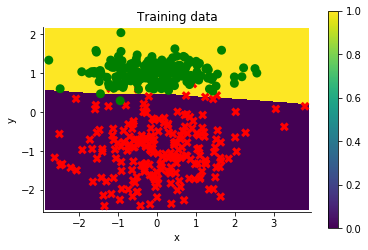

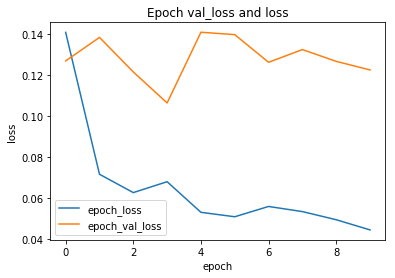

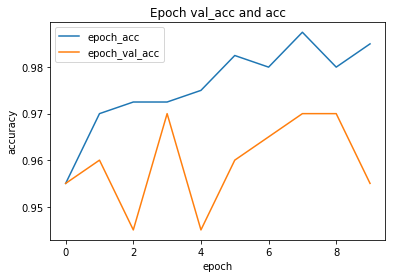


Loss on validation set:0.134414203791 Accuracy on validation set: 0.96


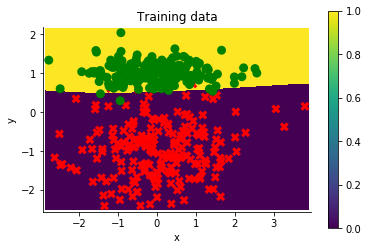

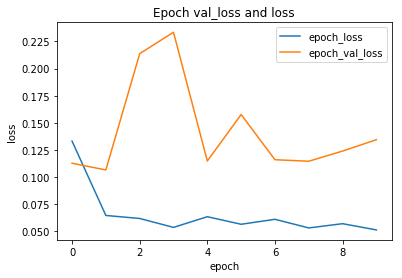

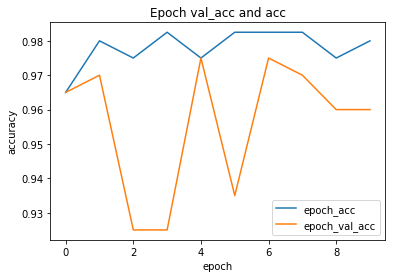


Loss on validation set:0.124127266586 Accuracy on validation set: 0.965


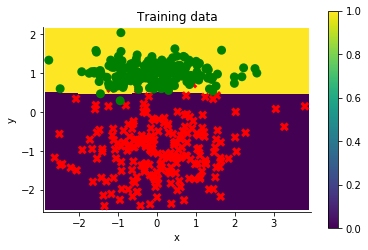

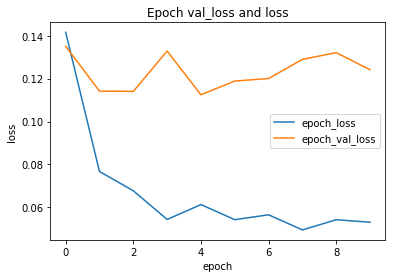

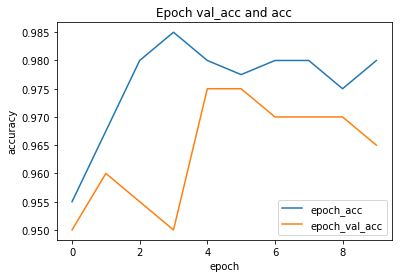


Avg. validation accuracy:0.962
('For data_num:', 4)
('Keras FC: dataset=', '4')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))

Loss on validation set:0.148607264328 Accuracy on validation set: 0.9525


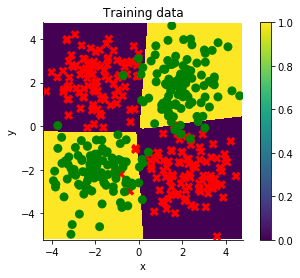

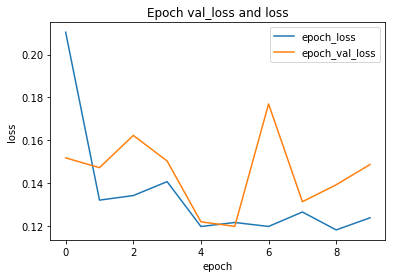

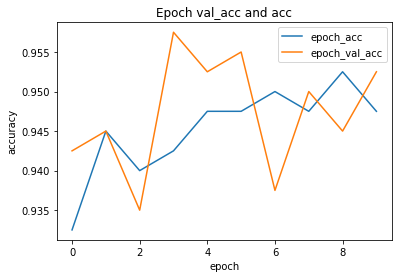


Loss on validation set:0.139861977269 Accuracy on validation set: 0.9525


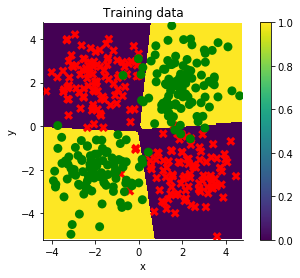

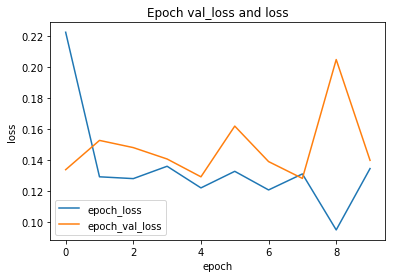

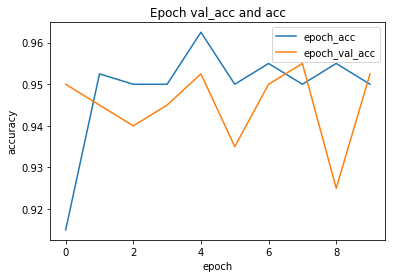


Loss on validation set:0.129370043038 Accuracy on validation set: 0.9525


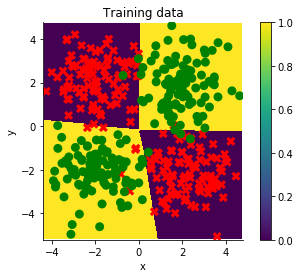

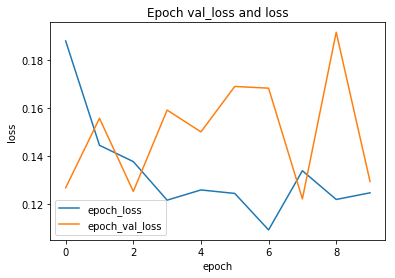

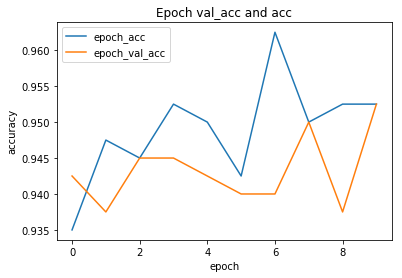


Loss on validation set:0.15344391106 Accuracy on validation set: 0.945


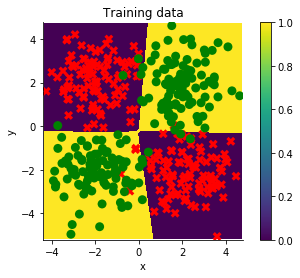

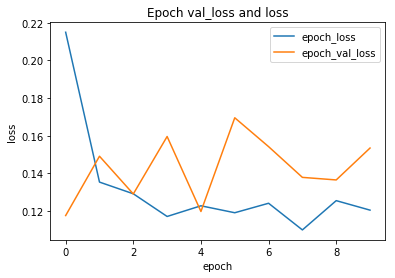

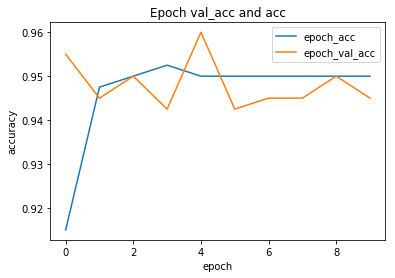


Loss on validation set:0.185217330234 Accuracy on validation set: 0.9375


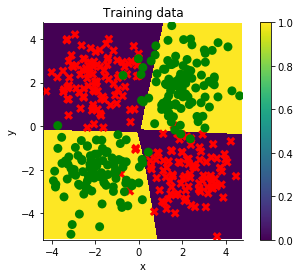

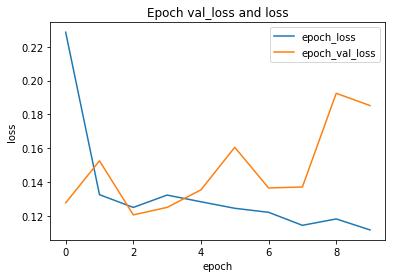

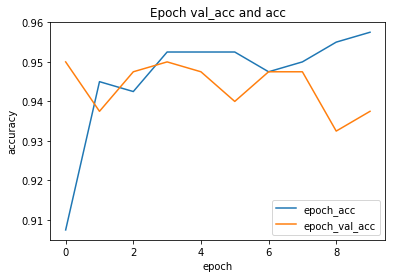


Avg. validation accuracy:0.948


In [6]:
for layer_num in range(5):
    print('For arch: ', layer_num)
    for data_num  in range(1,5):
        print('For data_num:', data_num)
        layers = archs(2)[layer_num]
        X_train, y, model = run_keras_2d(str(data_num), layers, 10, verbose=False, trials=5)

Training for data '3' using architecture (200,200) for 100 epochs.

('Keras FC: dataset=', '3')
Convert from -1,1 to 0,1
('Loading X', (400, 2), 'y', (400,), 'classes', set([0.0, 1.0]))
Convert from -1,1 to 0,1
('Loading X', (200, 2), 'y', (200,), 'classes', set([0.0, 1.0]))
Train on 400 samples, validate on 200 samples
Epoch 1/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1527 - acc: 0.9450 - val_loss: 0.1309 - val_acc: 0.9500
Epoch 2/100
400/400 [==============================] - 1s 4ms/step - loss: 0.0749 - acc: 0.9700 - val_loss: 0.1150 - val_acc: 0.9700
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.0635 - acc: 0.9800 - val_loss: 0.1076 - val_acc: 0.9750
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0560 - acc: 0.9800 - val_loss: 0.1195 - val_acc: 0.9700
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0561 - acc: 0.9850 - val_loss: 0.1238 - val_acc: 0.9700
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0525

400/400 [==============================] - 1s 2ms/step - loss: 0.0355 - acc: 0.9900 - val_loss: 0.1817 - val_acc: 0.9700
Epoch 61/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0333 - acc: 0.9900 - val_loss: 0.2062 - val_acc: 0.9700
Epoch 62/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0310 - acc: 0.9850 - val_loss: 0.1912 - val_acc: 0.9700
Epoch 63/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0389 - acc: 0.9875 - val_loss: 0.1956 - val_acc: 0.9700
Epoch 64/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0353 - acc: 0.9900 - val_loss: 0.1749 - val_acc: 0.9700
Epoch 65/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0387 - acc: 0.9825 - val_loss: 0.2025 - val_acc: 0.9700
Epoch 66/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0358 - acc: 0.9900 - val_loss: 0.2022 - val_acc: 0.9700
Epoch 67/100
400/400 [==============================] - 1s 2ms/step - loss:

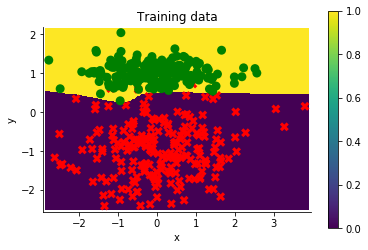

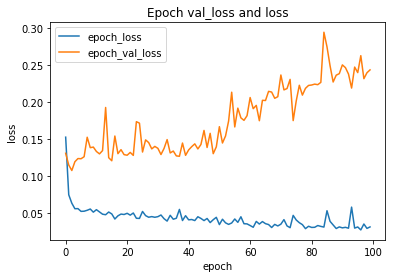

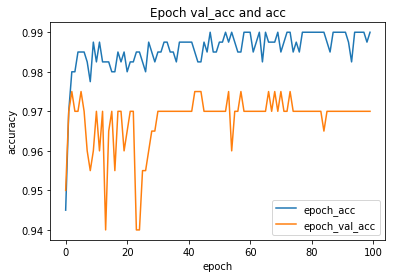


Avg. validation accuracy:0.97


In [4]:
layers = archs(2)[4]
X_train, y, model = run_keras_2d('3', layers, 100)


What is the average validation accuracy (using split=0.5) for the three-class data set (data_name=3class), for each of the architectures, using 10 epochs and 5 trials as before. 

In [6]:
for layer_num in range(5):
    print('For arch: ', layer_num)
    layers = archs(3)[layer_num]
    X_train, y, model = run_keras_2d('3class', layers, 10, display=False, split=0.5, verbose=False, trials=5)

('For arch: ', 0)
('Keras FC: dataset=', '3class')
('Loading X', (800, 2), 'y', (800,), 'classes', set([0.0, 1.0, 2.0]))

Loss on validation set:0.4403436852 Accuracy on validation set: 0.875

Loss on validation set:0.406316316359 Accuracy on validation set: 0.88

Loss on validation set:0.384379936038 Accuracy on validation set: 0.8975

Loss on validation set:0.451541296805 Accuracy on validation set: 0.8725

Loss on validation set:0.383233431943 Accuracy on validation set: 0.8925

Avg. validation accuracy:0.8835
('For arch: ', 1)
('Keras FC: dataset=', '3class')
('Loading X', (800, 2), 'y', (800,), 'classes', set([0.0, 1.0, 2.0]))

Loss on validation set:0.216404623457 Accuracy on validation set: 0.9325

Loss on validation set:0.189673715452 Accuracy on validation set: 0.9475

Loss on validation set:0.205759375443 Accuracy on validation set: 0.9375

Loss on validation set:0.216676938695 Accuracy on validation set: 0.945

Loss on validation set:0.224780080325 Accuracy on validation set

('Keras FC: dataset=', '3class')
('Loading X', (800, 2), 'y', (800,), 'classes', set([0.0, 1.0, 2.0]))

Loss on validation set:0.354589740769 Accuracy on validation set: 0.88


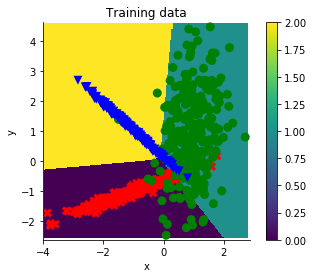

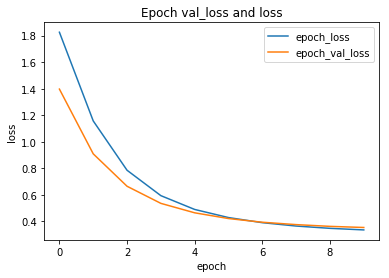

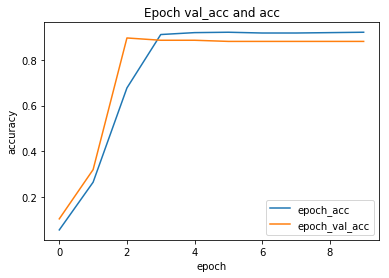


Loss on validation set:0.35565010607 Accuracy on validation set: 0.875


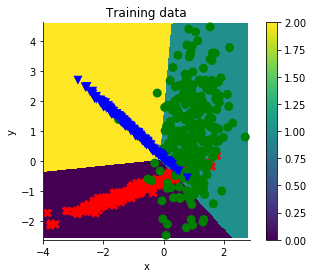

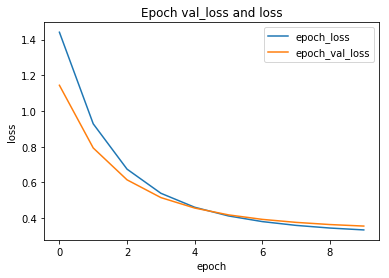

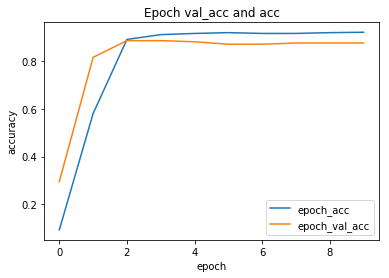


Loss on validation set:0.351499614594 Accuracy on validation set: 0.875


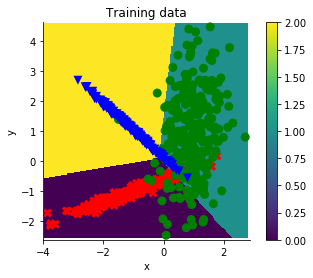

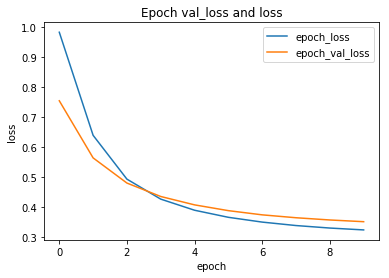

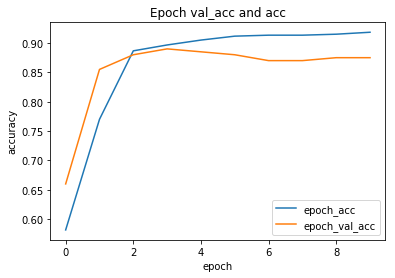


Loss on validation set:0.338960806398 Accuracy on validation set: 0.88


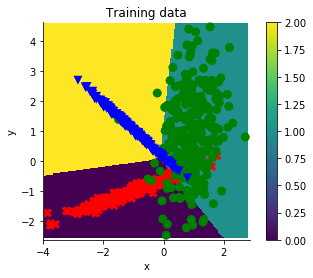

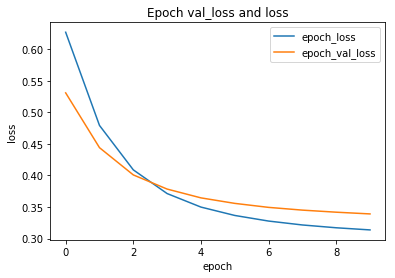

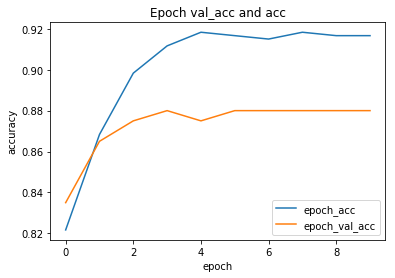


Loss on validation set:0.344617787042 Accuracy on validation set: 0.875


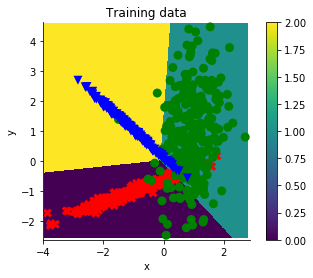

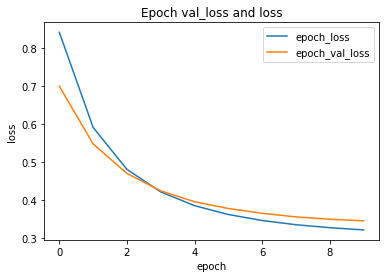

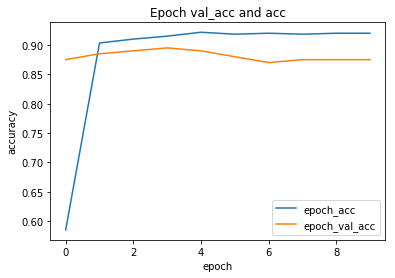


Avg. validation accuracy:0.877


In [27]:
# Using no arch 0 on 3class data 
layers = archs(3)[0]
X_train, y, model = run_keras_2d('3class', layers, 10, display=True, split=0.25, verbose=False, trials=5)

In [28]:
inputs = [[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]]
weights = layers[0].get_weights()
W, W0 = weights
print(weights)
W = np.asarray(W)
W0 = np.asarray(W0)
out = []
for x in inputs:
    x = np.asarray(x)
    val = np.dot(W.T, x)+W0
    out.append(list(val))


[array([[ 0.08867367,  2.62792993, -0.19921261],
       [-1.36119843,  0.97592849,  1.18453526]], dtype=float32), array([-0.04710489,  0.13582934, -0.10368661], dtype=float32)]


In [29]:
out

[[-0.13577855378389359, -2.4921005815267563, 0.09552600234746933],
 [0.041568778455257416, 2.7637592703104019, -0.30289921909570694],
 [14.926077790558338, -10.599383994936943, -13.133574523031712],
 [-1.4083033129572868, 1.111757829785347, 1.0808486565947533],
 [1.2254198715090752, -3.4680290669202805, -1.0890092626214027],
 [-1.4969769790768623, -1.5161720961332321, 1.2800612673163414],
 [-1.3196296468377113, 3.7396877557039261, 0.88163604587316513],
 [1.4027672037482262, 1.7878307849168777, -1.487434484064579]]

In [36]:
inputs = [[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]]

x= np.array([-1,0])

model.predict(np.array([-1,0]))

ValueError: Error when checking : expected dense_100_input to have shape (2,) but got array with shape (1,)

In [37]:
train, validation = get_MNIST_data()

11501568/11490434 [==============================] - 5s 0us/step


In [43]:
layers=[Dense(input_dim=28*28, units=10, activation="softmax")]
run_keras_fc_mnist(train, validation, layers, epochs=10, split=0.1, trials=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 105us/step - loss: 10.4765 - acc: 0.3477 - val_loss: 10.2532 - val_acc: 0.3621
Epoch 2/10
60000/60000 [==============================] - 5s 86us/step - loss: 10.2042 - acc: 0.3658 - val_loss: 10.1293 - val_acc: 0.3708
Epoch 3/10
60000/60000 [==============================] - 5s 76us/step - loss: 10.1801 - acc: 0.3676 - val_loss: 10.0725 - val_acc: 0.3742
Epoch 4/10
60000/60000 [==============================] - 5s 79us/step - loss: 10.0973 - acc: 0.3729 - val_loss: 9.6424 - val_acc: 0.4000
Epoch 5/10
60000/60000 [==============================] - 5s 77us/step - loss: 9.0681 - acc: 0.4361 - val_loss: 8.8871 - val_acc: 0.4476
Epoch 6/10
60000/60000 [==============================] - 5s 91us/step - loss: 8.9191 - acc: 0.4455 - val_loss: 8.8246 - val_acc: 0.4517
Epoch 7/10
60000/60000 [==============================] - 5s 79us/step - loss: 8.8269 - acc: 0.4515 - val_loss: 8.7807 -

In [46]:
# added initializer to the layer
layers=[Dense(input_dim=28*28, units=10, activation="softmax", kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None))]
run_keras_fc_mnist(train, validation, layers, epochs=10, split=0.1, trials=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 97us/step - loss: 3.3350 - acc: 0.7779 - val_loss: 2.1452 - val_acc: 0.8575
Epoch 2/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.9747 - acc: 0.8710 - val_loss: 2.0049 - val_acc: 0.8687
Epoch 3/10
60000/60000 [==============================] - 6s 101us/step - loss: 1.8243 - acc: 0.8817 - val_loss: 1.4978 - val_acc: 0.9032
Epoch 4/10
60000/60000 [==============================] - 7s 119us/step - loss: 1.7166 - acc: 0.8897 - val_loss: 1.7639 - val_acc: 0.8866
Epoch 5/10
60000/60000 [==============================] - 7s 115us/step - loss: 1.7235 - acc: 0.8899 - val_loss: 1.5836 - val_acc: 0.8991
Epoch 6/10
60000/60000 [==============================] - 8s 130us/step - loss: 1.6262 - acc: 0.8961 - val_loss: 1.4900 - val_acc: 0.9051
Epoch 7/10
60000/60000 [==============================] - 9s 147us/step - loss: 1.7131 - acc: 0.8909 - val_loss: 1.4451 - va

In [50]:
# Data scaled
layers=[Dense(input_dim=28*28, units=10, activation="softmax")]
def rescale(data):
    data_rescale = []
    for i in range(len(data)):
        data_rescale.append(data[i]/255.)
    return tuple(data_rescale)
train = rescale(train)
validation = rescale(validation)
run_keras_fc_mnist(train, validation, layers, epochs=10, split=0.1, trials=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 105us/step - loss: 1.0844 - acc: 0.9995 - val_loss: 0.3636 - val_acc: 1.0000
Epoch 2/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.1825 - acc: 1.0000 - val_loss: 0.0842 - val_acc: 1.0000
Epoch 3/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.0502 - acc: 1.0000 - val_loss: 0.0280 - val_acc: 1.0000
Epoch 4/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 5/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 6/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 7/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 7.0088e-04 - va

In [53]:
for epoch in [5, 10, 15]:
    print('for epoch:', epoch)
    layer=[Dense(input_dim=28*28, units=10, activation="softmax")]
    run_keras_fc_mnist(train, validation, layer, epoch, split=0.1, verbose=False, trials=5)

('for epoch:', 5)

Loss on validation set:0.00420970585644 Accuracy on validation set: 1.0

Loss on validation set:0.00421048603132 Accuracy on validation set: 1.0

Loss on validation set:0.0042095932655 Accuracy on validation set: 1.0

Loss on validation set:0.00420937299356 Accuracy on validation set: 1.0


KeyboardInterrupt: 

In [59]:
train, validation = get_MNIST_data()
def rescale(data):
    X, y = data
    X = X/255.
    return (X,y)
train = rescale(train)
validation = rescale(validation)
for unit in (128, 256, 512, 1024):
    print('units: ', unit)
    arch = [Dense(input_dim=28*28, units=unit, activation="relu"),
    Dense(units=10, activation="softmax")]
    run_keras_fc_mnist(train, validation, arch, epochs=1, split=0.1, verbose=False, trials=5)

('units: ', 128)

Loss on validation set:0.13311705662 Accuracy on validation set: 0.9618

Loss on validation set:0.149695271349 Accuracy on validation set: 0.9547

Loss on validation set:0.134426710214 Accuracy on validation set: 0.9595

Loss on validation set:0.149208645016 Accuracy on validation set: 0.9553

Loss on validation set:0.137168698724 Accuracy on validation set: 0.9592

Avg. validation accuracy:0.9581
('units: ', 256)

Loss on validation set:0.117424297679 Accuracy on validation set: 0.9659

Loss on validation set:0.116534343314 Accuracy on validation set: 0.9649

Loss on validation set:0.11212136788 Accuracy on validation set: 0.9672

Loss on validation set:0.114809101362 Accuracy on validation set: 0.963

Loss on validation set:0.12182594457 Accuracy on validation set: 0.9643

Avg. validation accuracy:0.96506
('units: ', 512)

Loss on validation set:0.107876550855 Accuracy on validation set: 0.9669

Loss on validation set:0.0995648552068 Accuracy on validation set: 0.96

In [61]:
arch = [Dense(input_dim=28*28, units=512, activation="relu"),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation="softmax")]
run_keras_fc_mnist(train, validation, arch, epochs=1, split=0.1, verbose=False, trials=5)


Loss on validation set:0.102195395952 Accuracy on validation set: 0.9688

Loss on validation set:0.102776314196 Accuracy on validation set: 0.9678

Loss on validation set:0.0896040018988 Accuracy on validation set: 0.9705

Loss on validation set:0.10827023098 Accuracy on validation set: 0.9661

Loss on validation set:0.105607898803 Accuracy on validation set: 0.9666

Avg. validation accuracy:0.96796


In [69]:
FC_Layer = [Dense(input_dim=48*48, units=512, activation="relu"),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation="softmax")]

In [68]:
# Trying cnn:
CNN_layers = [Conv2D(filters=32, kernel_size=(3,3),input_shape=(48, 48, 1), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
          MaxPooling2D(pool_size=(2, 2)), 
          Flatten(),
          Dense(units=128, activation='relu'),
          Dropout(rate = .5),
          Dense(units=10, activation='softmax')]


In [ ]:
layers = [Conv2D(filters=32, kernel_size=(3,3),input_shape=(28, 28, 1), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
          MaxPooling2D(pool_size=(2, 2)), 
          Flatten(),
          Dense(units=128, activation='relu'),
          Dropout(rate = .5),
          Dense(units=10, activation='softmax')]

run_keras_cnn_mnist(train, validation, layers, epochs=1, split=0.1, verbose=False, trials=1)

In [70]:
# Shifted dataset
train_20, validation_20 = get_MNIST_data(shift=20)
train_20 = rescale(train_20)
validation_20 = rescale(validation_20)
print('FC result')
run_keras_fc_mnist(train_20, validation_20, FC_Layer, epochs=1, split=0.1, verbose=False, trials=5)
print('CNN result')
run_keras_cnn_mnist(train_20, validation_20, CNN_layers, epochs=1, split=0.1, verbose=False, trials=1)

FC result

Loss on validation set:0.403667094457 Accuracy on validation set: 0.8715

Loss on validation set:0.429625317073 Accuracy on validation set: 0.8641

Loss on validation set:0.404798854506 Accuracy on validation set: 0.8692

Loss on validation set:0.399881825042 Accuracy on validation set: 0.8733

Loss on validation set:0.3868009377 Accuracy on validation set: 0.8786

Avg. validation accuracy:0.87134
CNN result

Loss on validation set:0.147597128287 Accuracy on validation set: 0.9564

Avg. validation accuracy:0.9564
